CSC 4370: Final Project - Ramita Rathore, Mahmuud Ibrahim, Aaron Grizzle, Dynaneshwari Jangale

Note: the dataset can be downloaded here: https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

The dataset comes from this GitHub repository: https://github.com/mdeff/fma

DATA PREPROCESSING

In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler

# This file comprises our dataset. It contains features derived from the original audio using librosa.
df = pd.read_csv('fma_metadata/features.csv', header=[0, 1, 2], skiprows=0, index_col=0)

# This file contains genre information for each instance.
tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0, 1], skiprows=0, index_col=0)

# This file maps genre IDs to names. It does not contain data points.
genres = pd.read_csv('fma_metadata/genres.csv')

print("Dataset:")
print(df.head())

print("\nShape of dataset:", df.shape)
print("Shape of track data:", tracks.shape)
print("Shape of genres:", genres.shape)

Dataset:
feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...              

In [2]:
# Remove duplicate instances from the dataset

print("Number of duplicate instances in the dataset:")
print(df.duplicated().sum())

tracks = tracks.drop(index=df[df.duplicated()].index)
df = df.drop_duplicates()

print("\nShape of dataset without duplicates:")
print(df.shape)

print("\nShape of tracks without duplicates:")
print(tracks.shape)

Number of duplicate instances in the dataset:
2111

Shape of dataset without duplicates:
(104463, 518)

Shape of tracks without duplicates:
(104463, 52)


In [3]:
# Remove instances with no target feature information.

print("Number of instances with no target value (genre information):")
print(sum(tracks[('track', 'genres_all')].str.len() <= 2))

df = df.drop(index=tracks[tracks[('track', 'genres_all')].str.len() <= 2].index)
tracks = tracks[tracks[('track', 'genres_all')].str.len() > 2]

print("\nShape of dataset without instances with no target value:")
print(df.shape)

print("\nShape of tracks without instances with no target value:")
print(tracks.shape)

Number of instances with no target value (genre information):
2128

Shape of dataset without instances with no target value:
(102335, 518)

Shape of tracks without instances with no target value:
(102335, 52)


In [4]:
# Check if there are any missing values in the descriptive features

print("Number of instances with a missing value in the descriptive features:")
print(sum(df.isnull().sum()))

Number of instances with a missing value in the descriptive features:
0


In [5]:
# Convert the values in the "genres_all" column into lists.

tracks['track', 'genres_all'] = tracks['track', 'genres_all'].map(ast.literal_eval)

FEATURE SELECTION AND VISUALIZATION

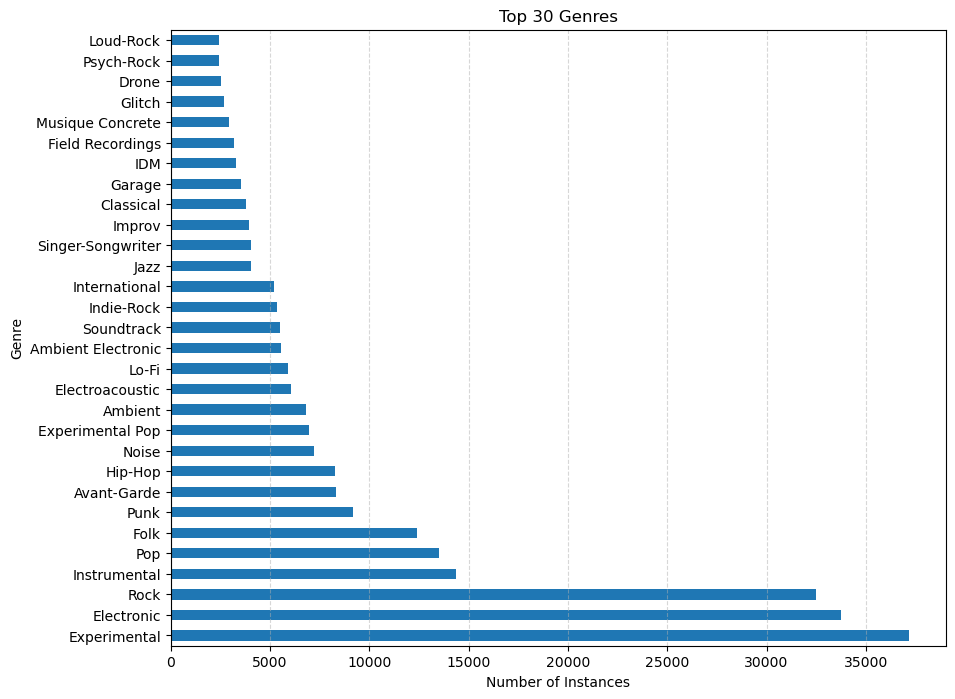

In [6]:
# Create a bar graph to show the top 30 genres.

# Get the number of occurences of each genre.
id_counts = tracks['track', 'genres_all'].explode().value_counts()

# Map the genre's ID to its name, then find the top 30.
id_title_dict = genres.set_index('genre_id')['title'].to_dict()
title_counts = id_counts.rename(index=id_title_dict)
top_30 = title_counts.head(30)

plt.figure(figsize=(10, 8))
top_30.plot(kind='barh')
plt.title('Top 30 Genres')
plt.xlabel('Number of Instances')
plt.ylabel('Genre')
plt.grid(axis='x', linestyle='--', alpha=0.5)

In [7]:
# Here is a possible feature selection based on domain knowledge.

chroma_cens_mean = df.loc[:, [('chroma_cens', 'mean', f'{i:02d}') for i in range(1, 13)]]
mfcc_mean = df.loc[:, [('mfcc', 'mean', f'{i:02d}') for i in range(1, 21)]]
spectral_contrast_mean = df.loc[:, [('spectral_contrast', 'mean', f'{i:02d}') for i in range(1, 8)]]
spectral_centroid_mean = df.loc[:, [('spectral_centroid', 'mean', '01')]]

df_selected = pd.concat([chroma_cens_mean, mfcc_mean, spectral_contrast_mean, spectral_centroid_mean], axis=1)
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102335 entries, 2 to 155320
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   (chroma_cens, mean, 01)        102335 non-null  float64
 1   (chroma_cens, mean, 02)        102335 non-null  float64
 2   (chroma_cens, mean, 03)        102335 non-null  float64
 3   (chroma_cens, mean, 04)        102335 non-null  float64
 4   (chroma_cens, mean, 05)        102335 non-null  float64
 5   (chroma_cens, mean, 06)        102335 non-null  float64
 6   (chroma_cens, mean, 07)        102335 non-null  float64
 7   (chroma_cens, mean, 08)        102335 non-null  float64
 8   (chroma_cens, mean, 09)        102335 non-null  float64
 9   (chroma_cens, mean, 10)        102335 non-null  float64
 10  (chroma_cens, mean, 11)        102335 non-null  float64
 11  (chroma_cens, mean, 12)        102335 non-null  float64
 12  (mfcc, mean, 01)              

/var/folders/pv/lb254lv959x3y4z6z_3p800h0000gn/T/ipykernel_15568/4160875250.py:11: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (3 levels on the left, 1 on the right)
  df_combined = df_selected.join(top_10_filtered.rename('genre'), how='inner')
/var/folders/pv/lb254lv959x3y4z6z_3p800h0000gn/T/ipykernel_15568/4160875250.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


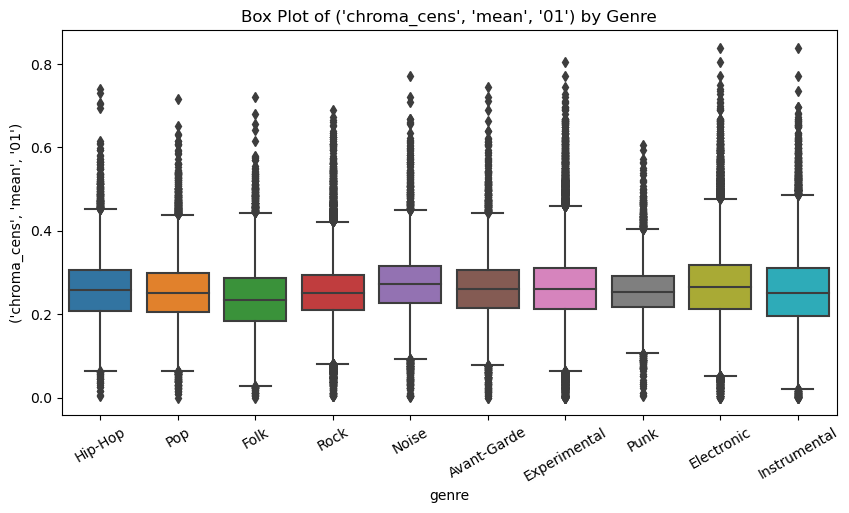

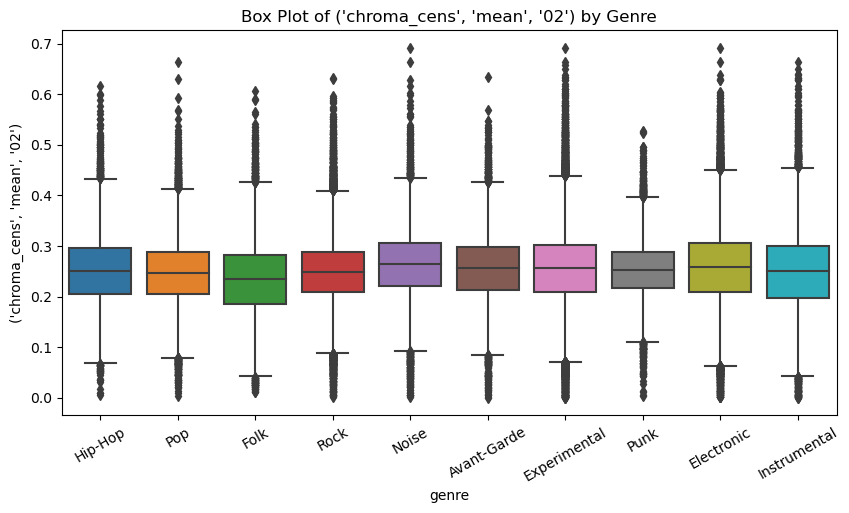

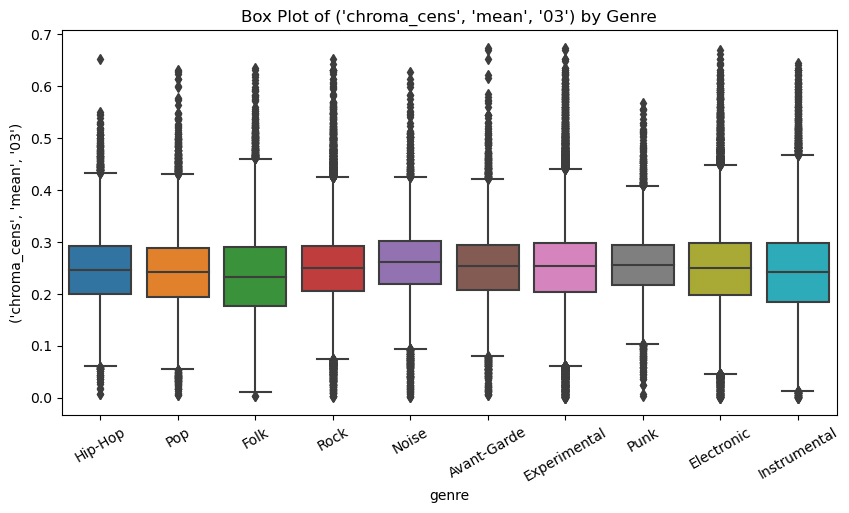

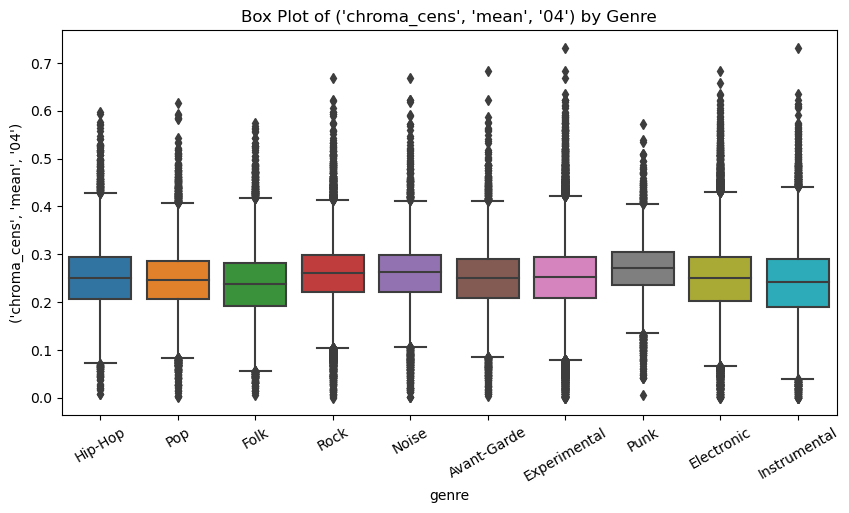

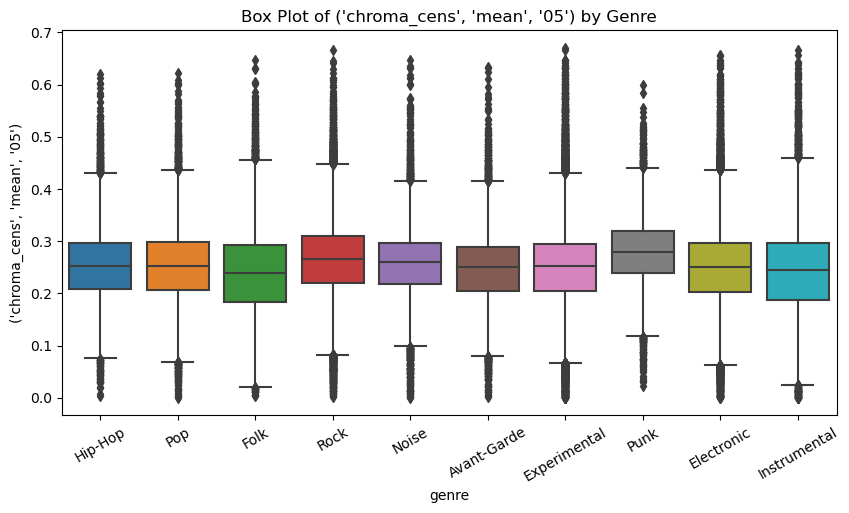

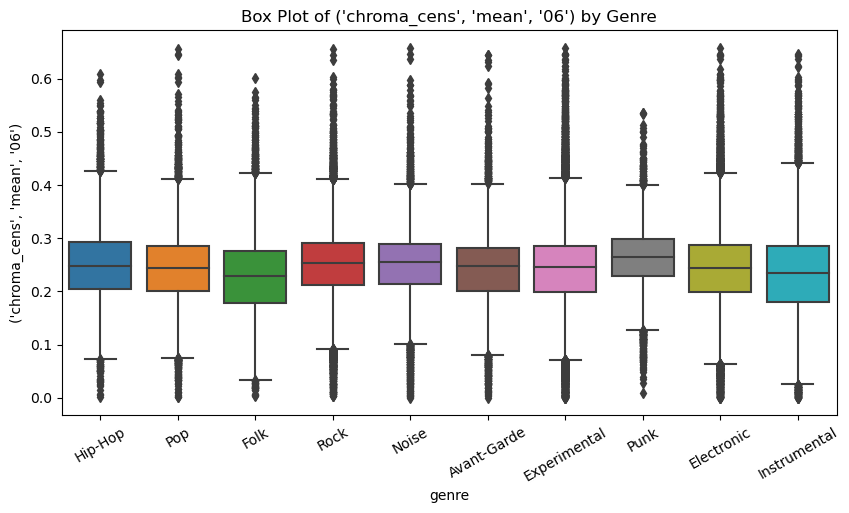

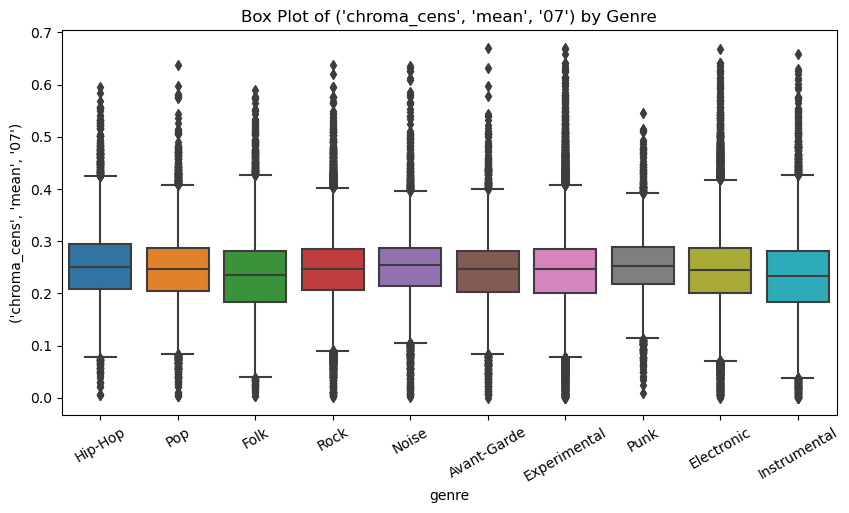

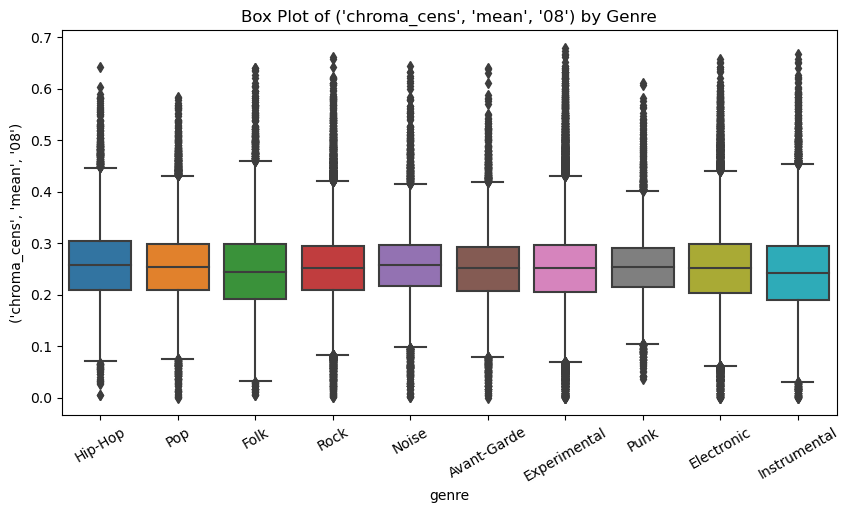

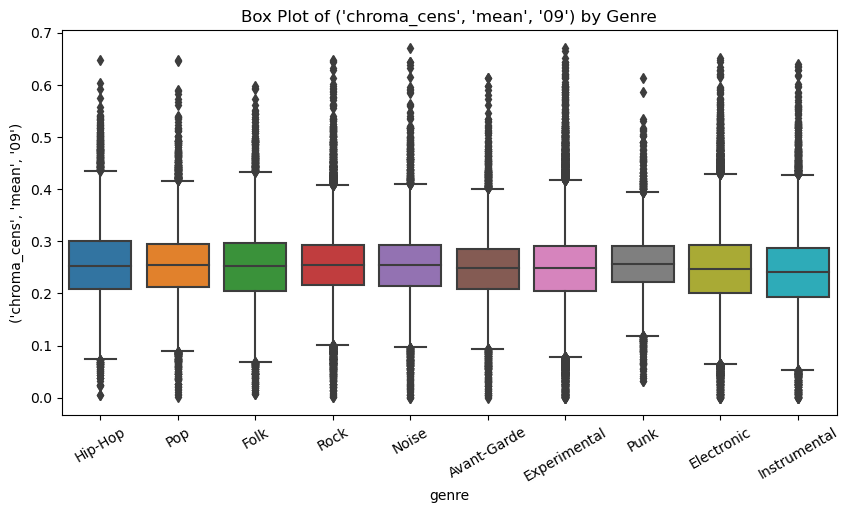

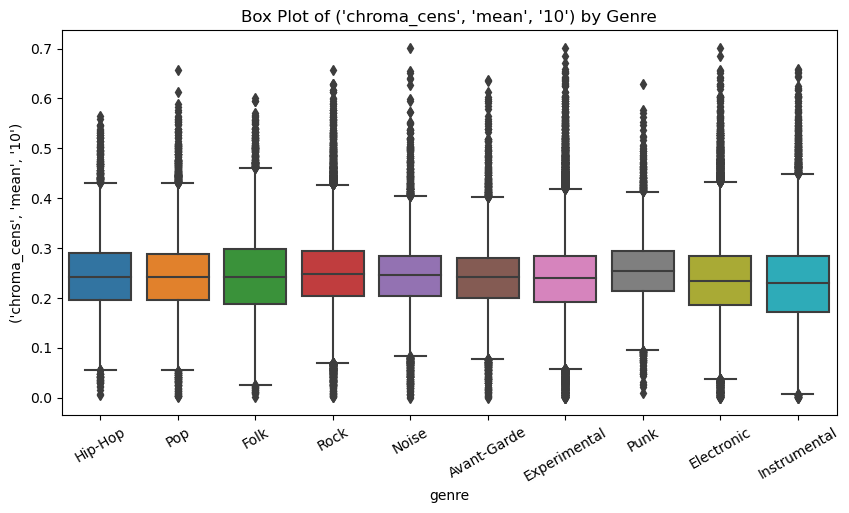

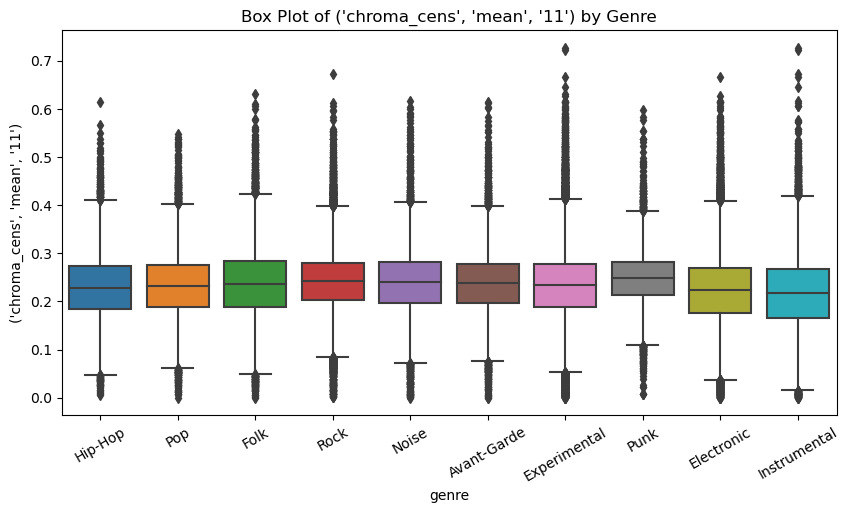

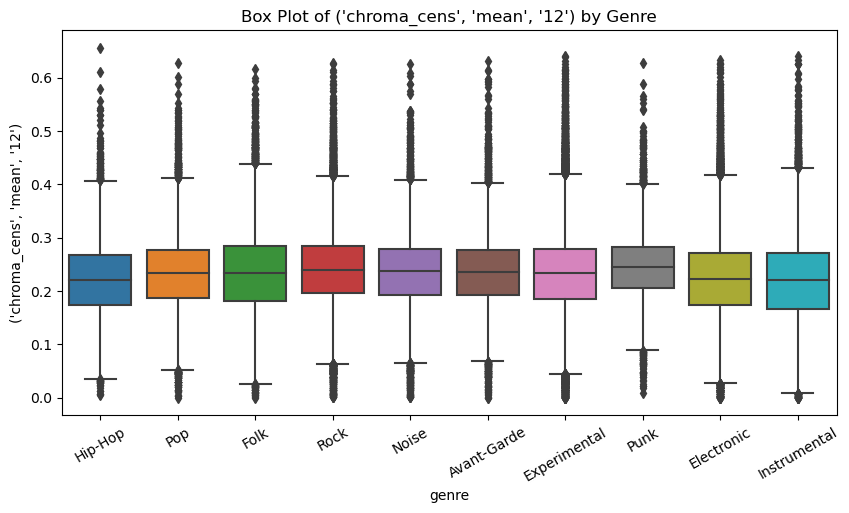

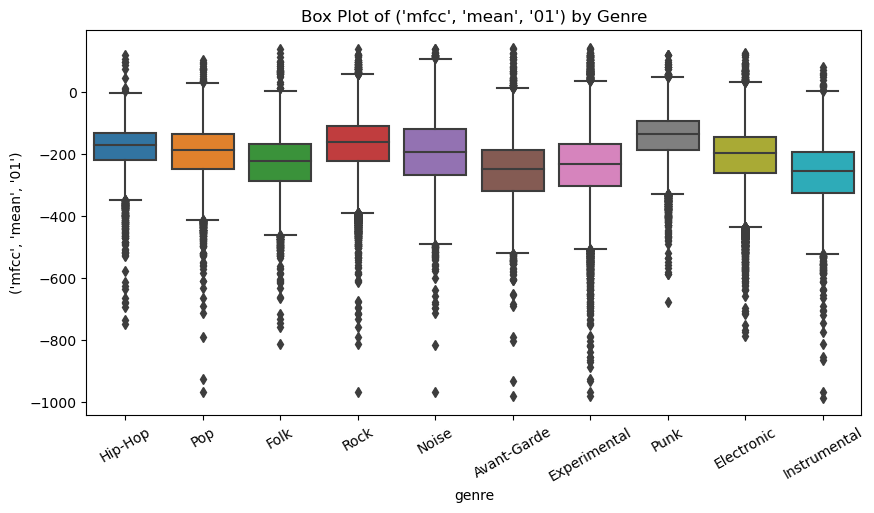

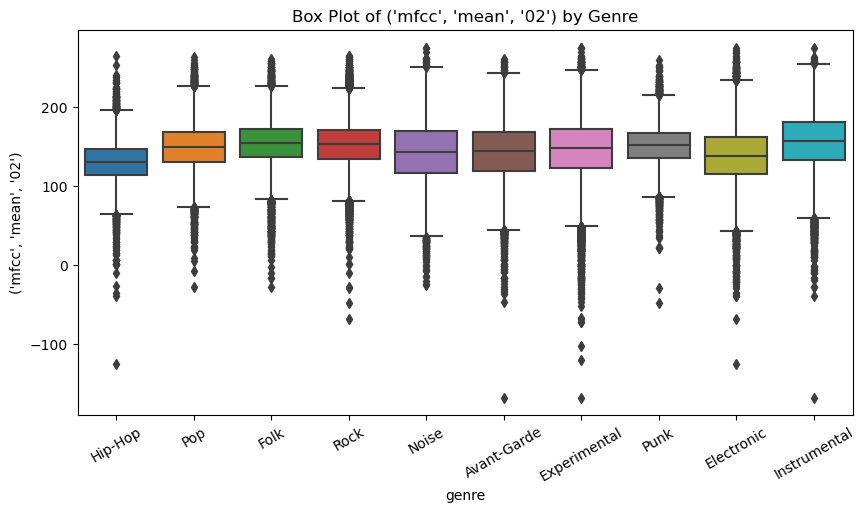

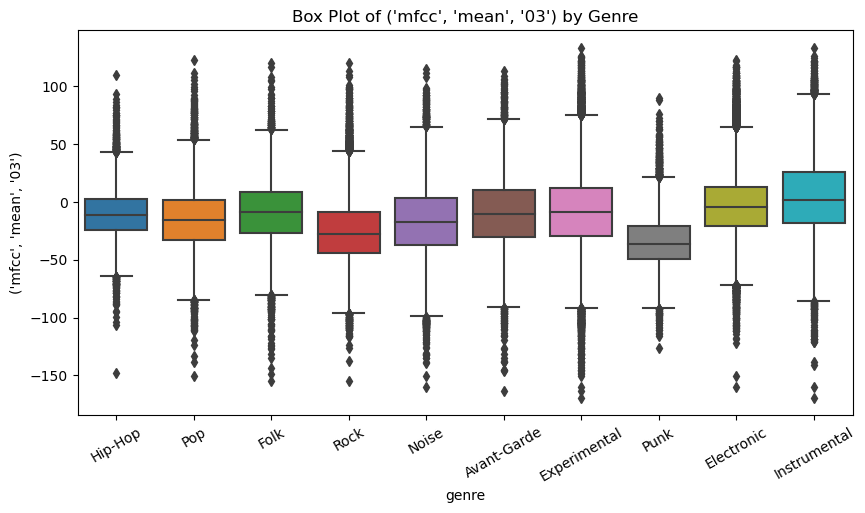

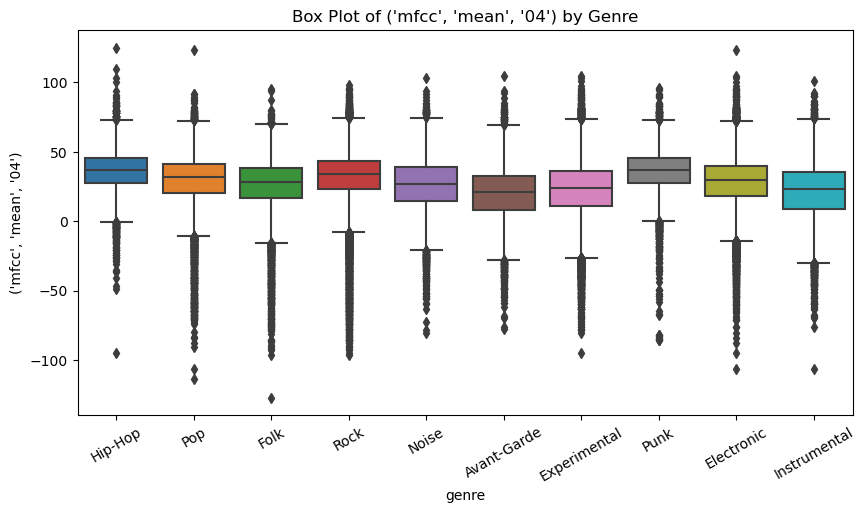

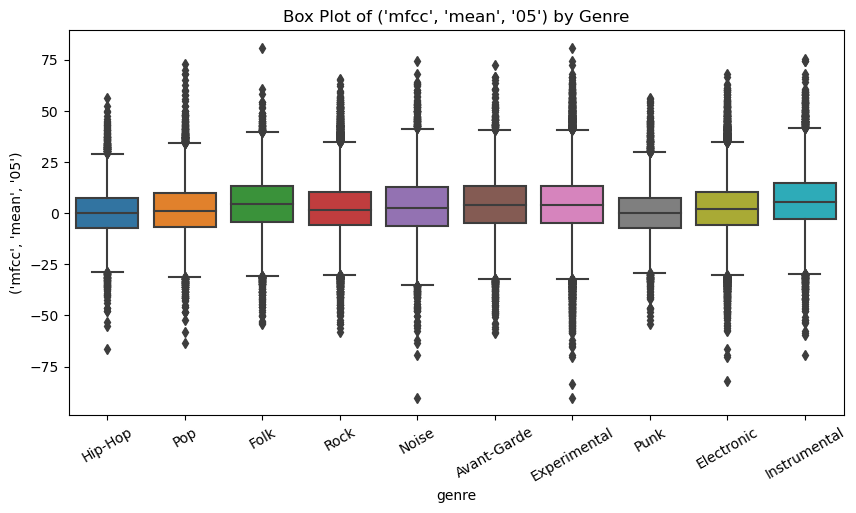

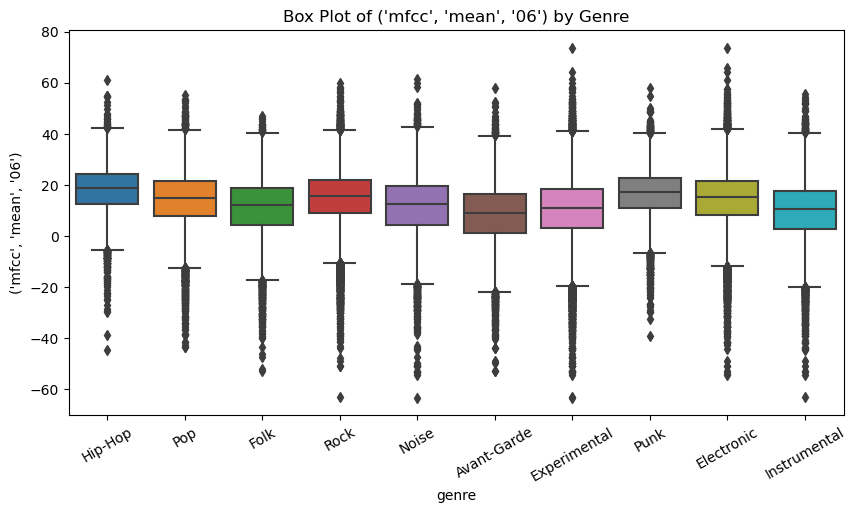

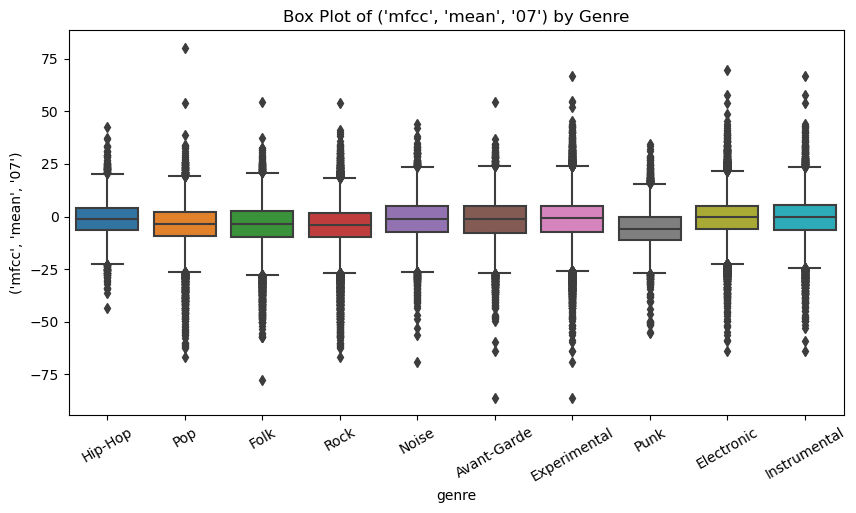

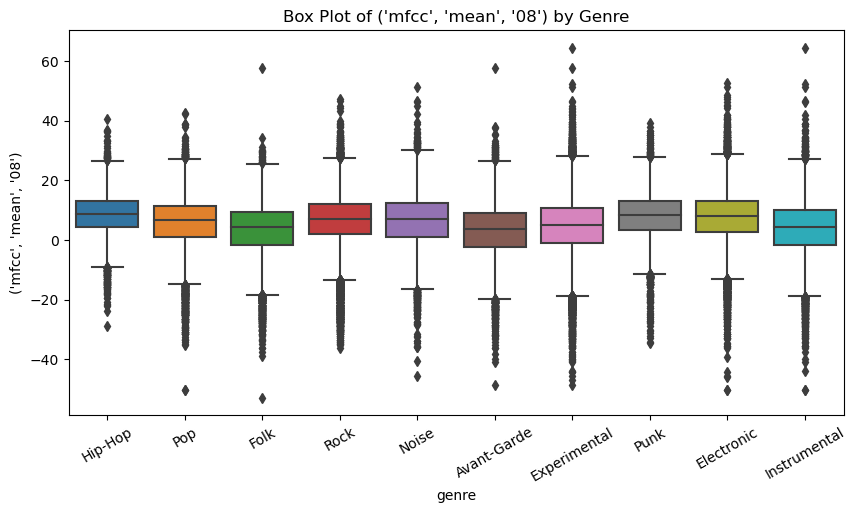

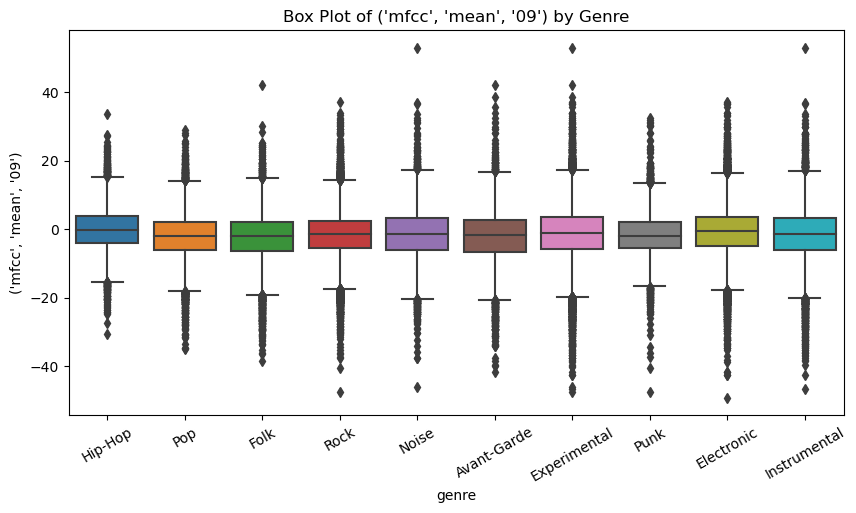

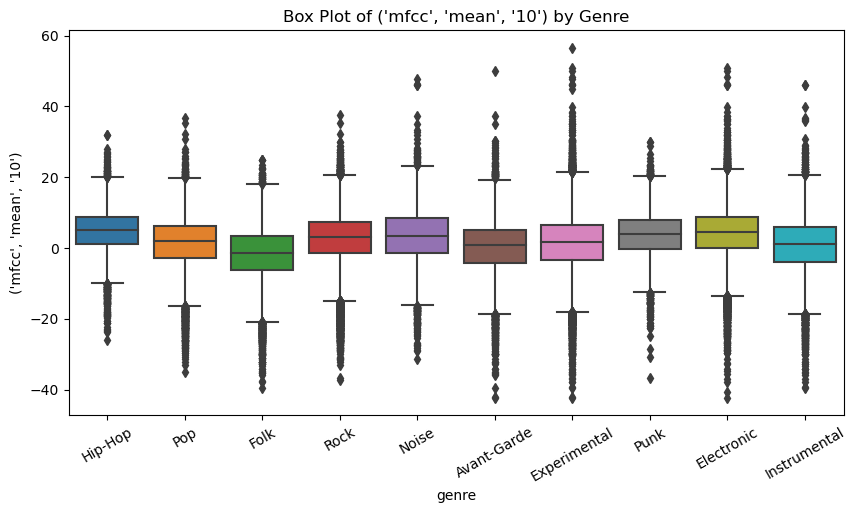

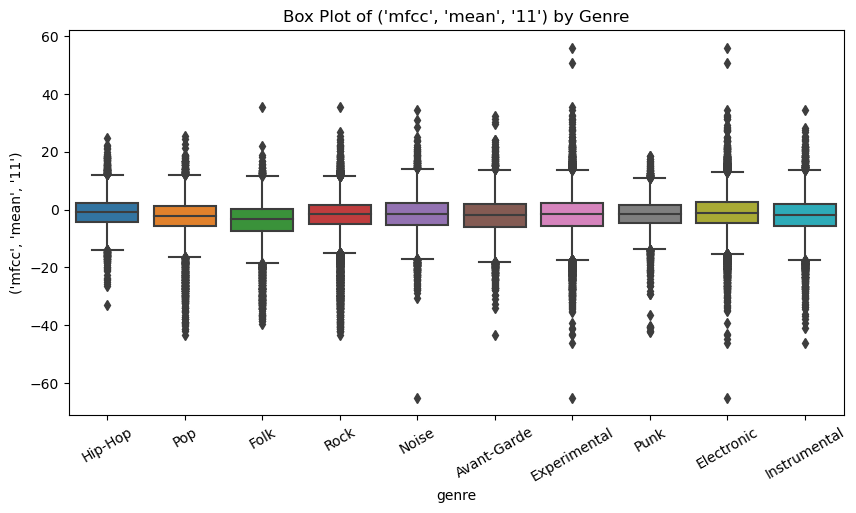

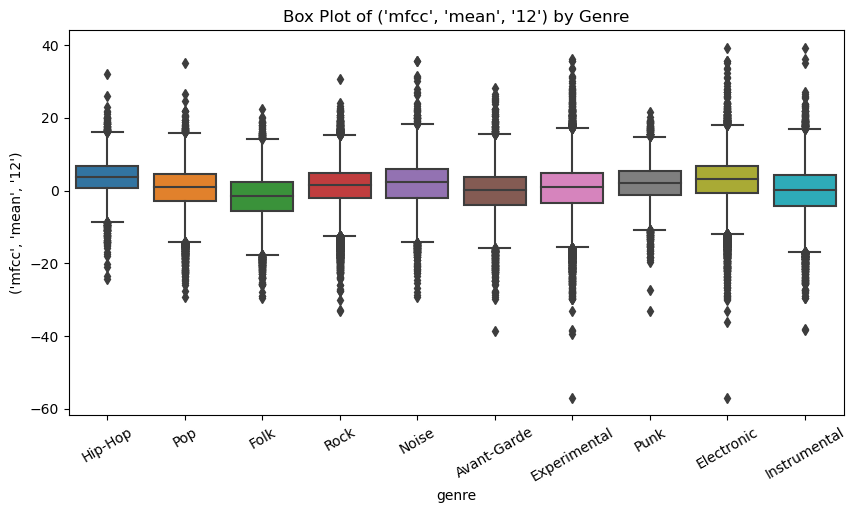

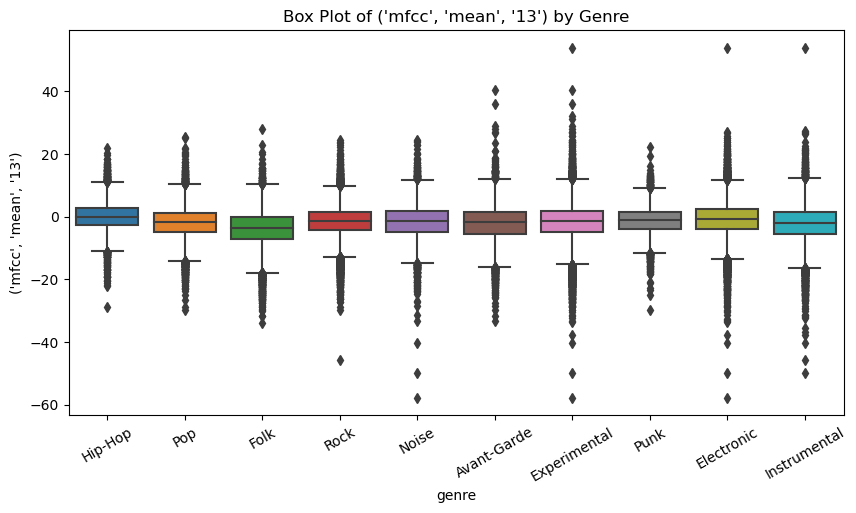

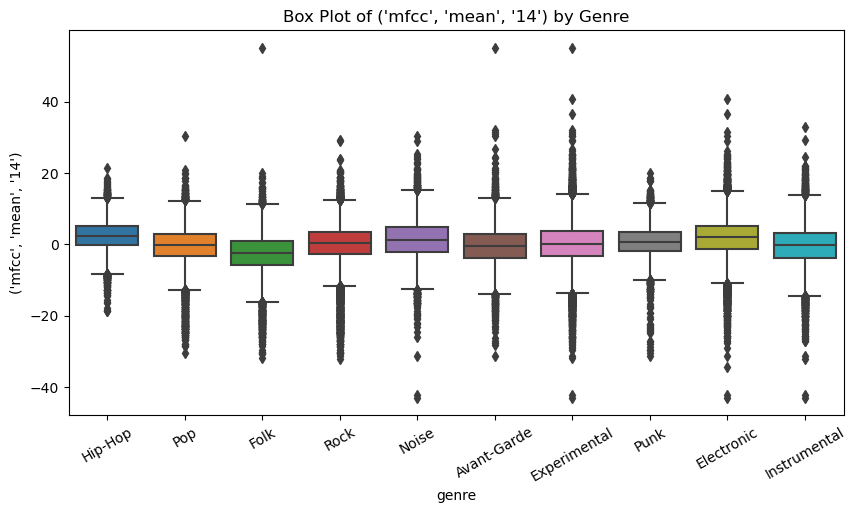

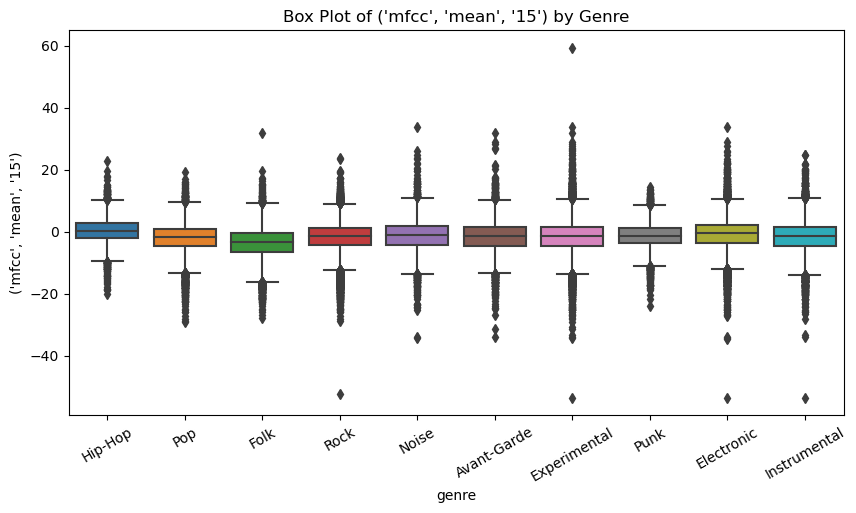

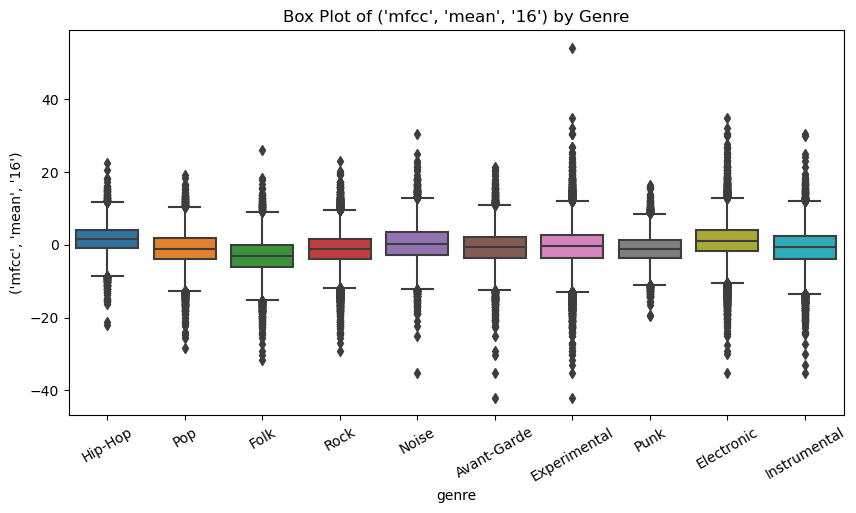

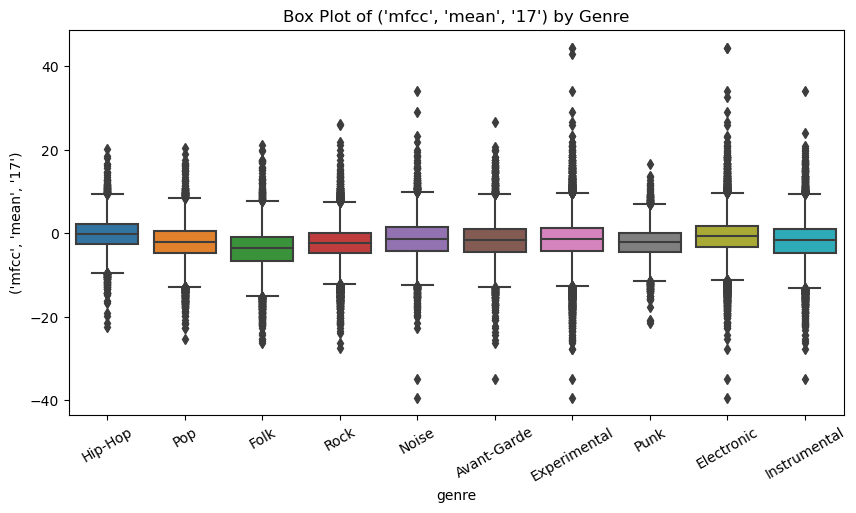

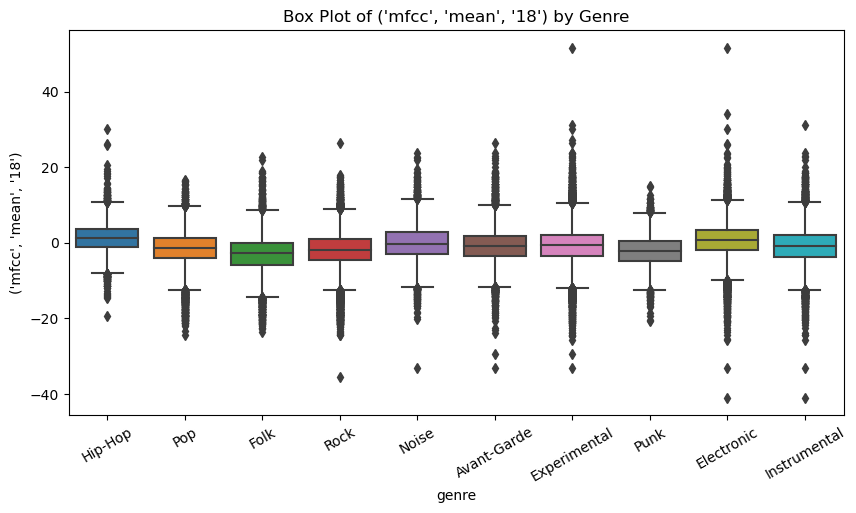

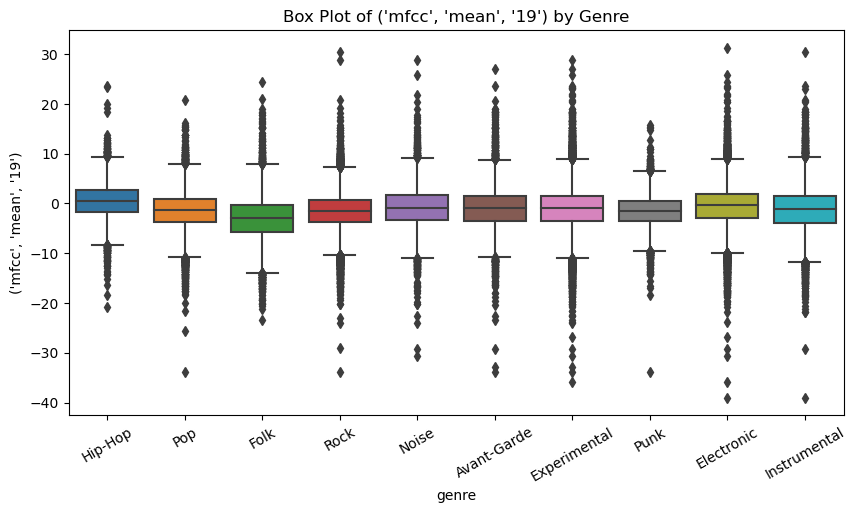

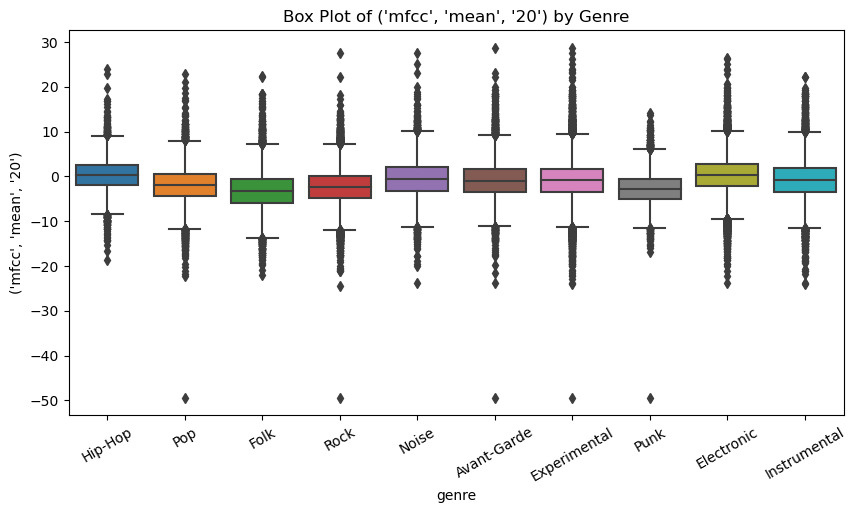

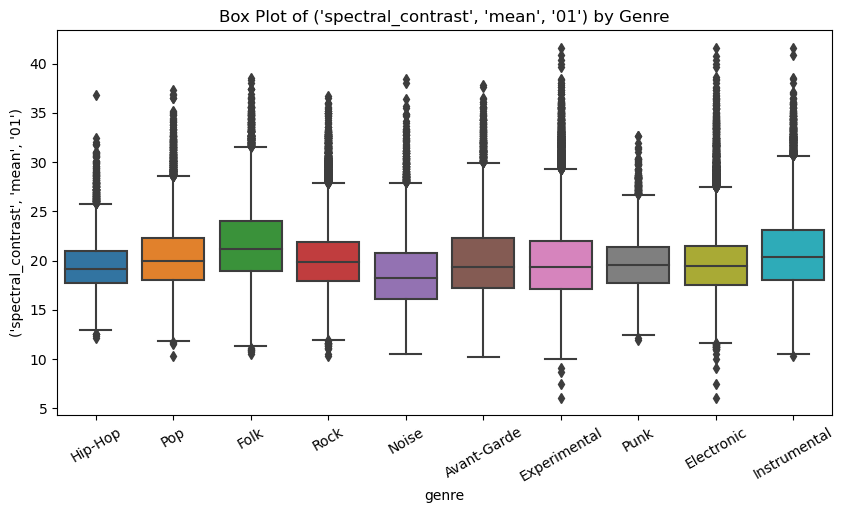

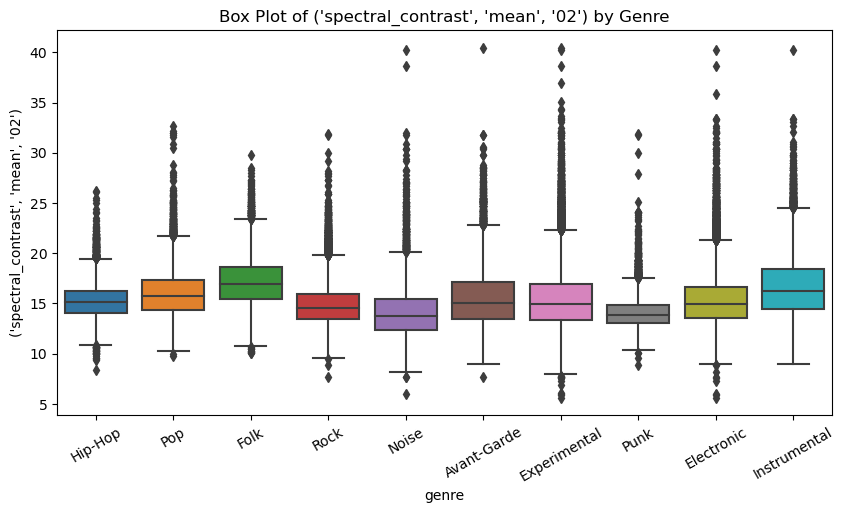

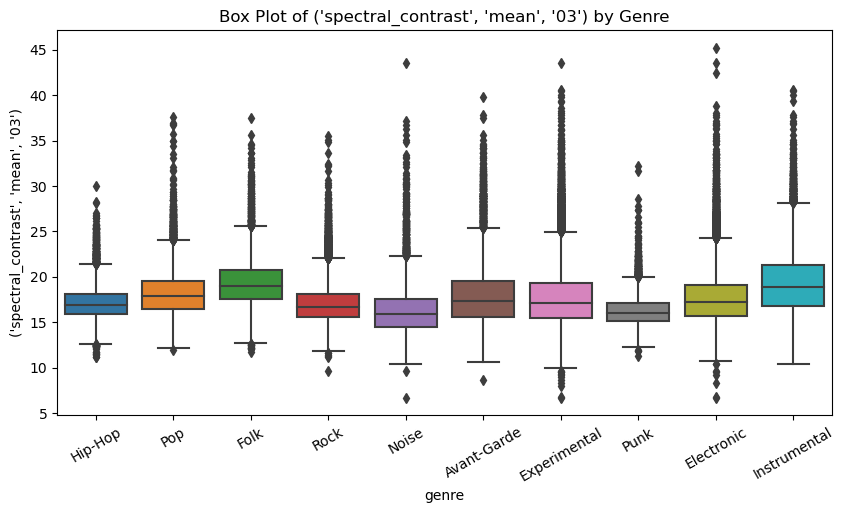

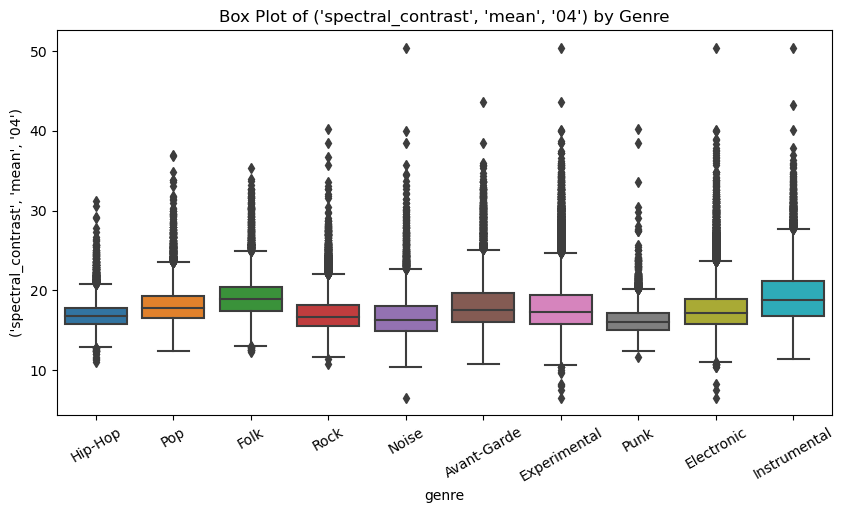

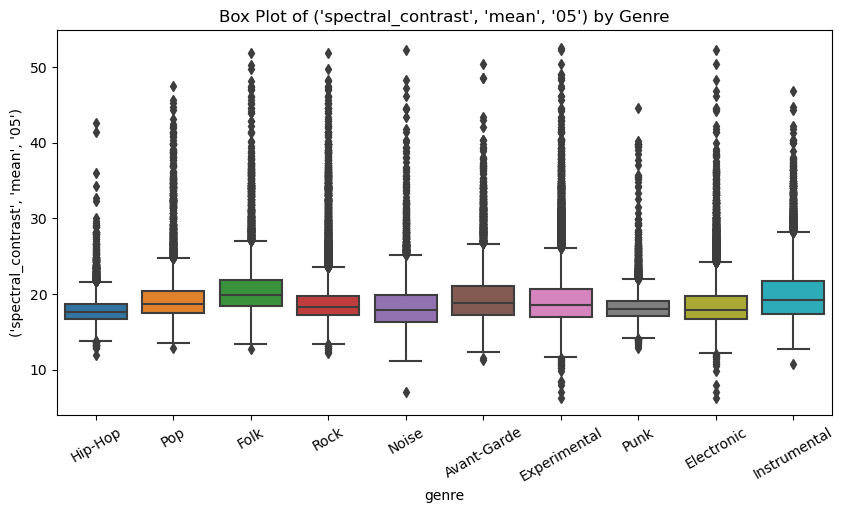

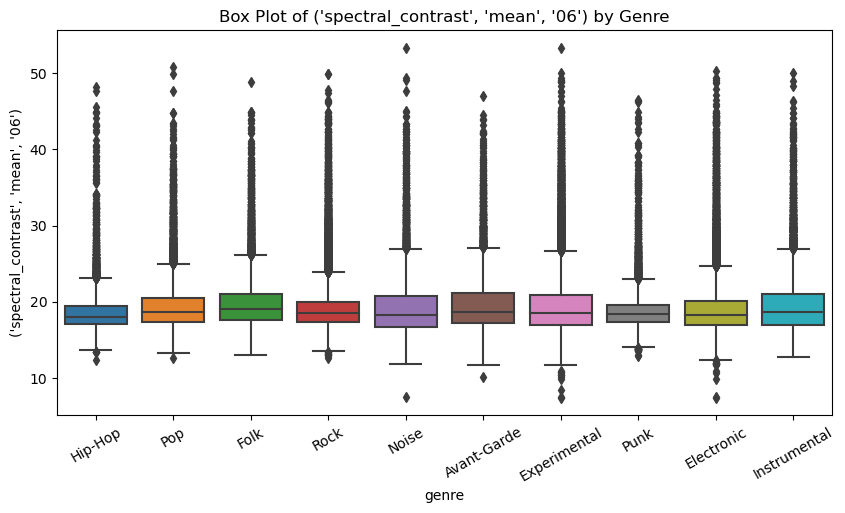

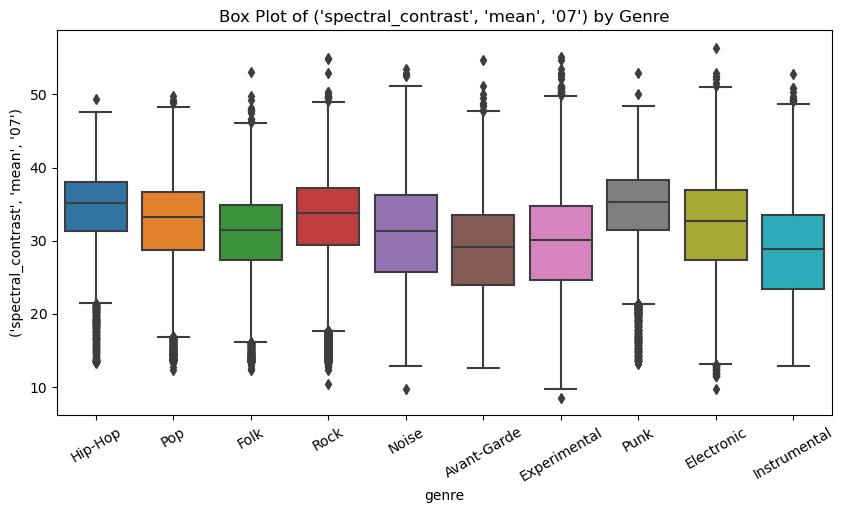

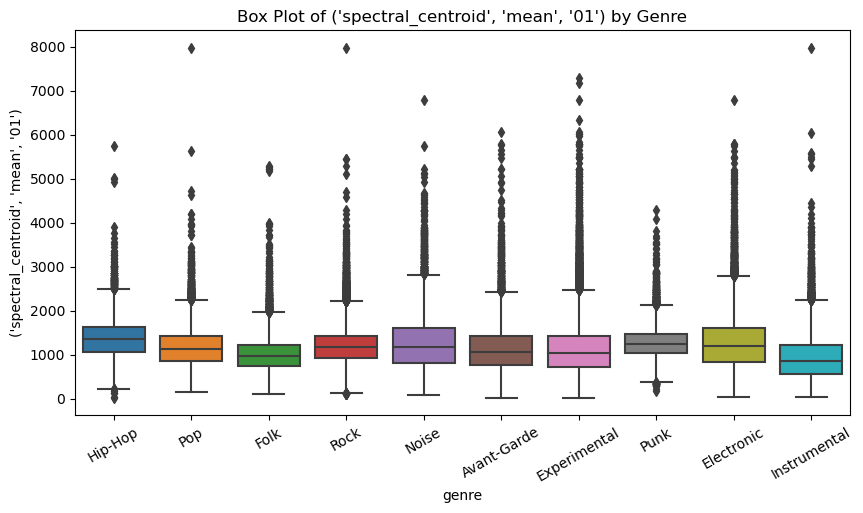

In [8]:
# Create box plots to show how well the selected features differentiate genres.

# Map the genres IDs to their name.
all_genres = tracks[('track', 'genres_all')].explode()
id_to_name = genres.set_index('genre_id')['title'].to_dict()
genres_mapped = all_genres.map(id_to_name)

# Select the top 10 genres, then join with the selected features.
top_10 = genres_mapped.value_counts().head(10).index
top_10_filtered = genres_mapped[genres_mapped.isin(top_10)]
df_combined = df_selected.join(top_10_filtered.rename('genre'), how='inner')

for column in df_selected.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='genre', y=column, data=df_combined)
    plt.title(f'Box Plot of {column} by Genre')
    plt.xticks(rotation=30)

<Axes: xlabel='feature-statistics-number', ylabel='feature-statistics-number'>

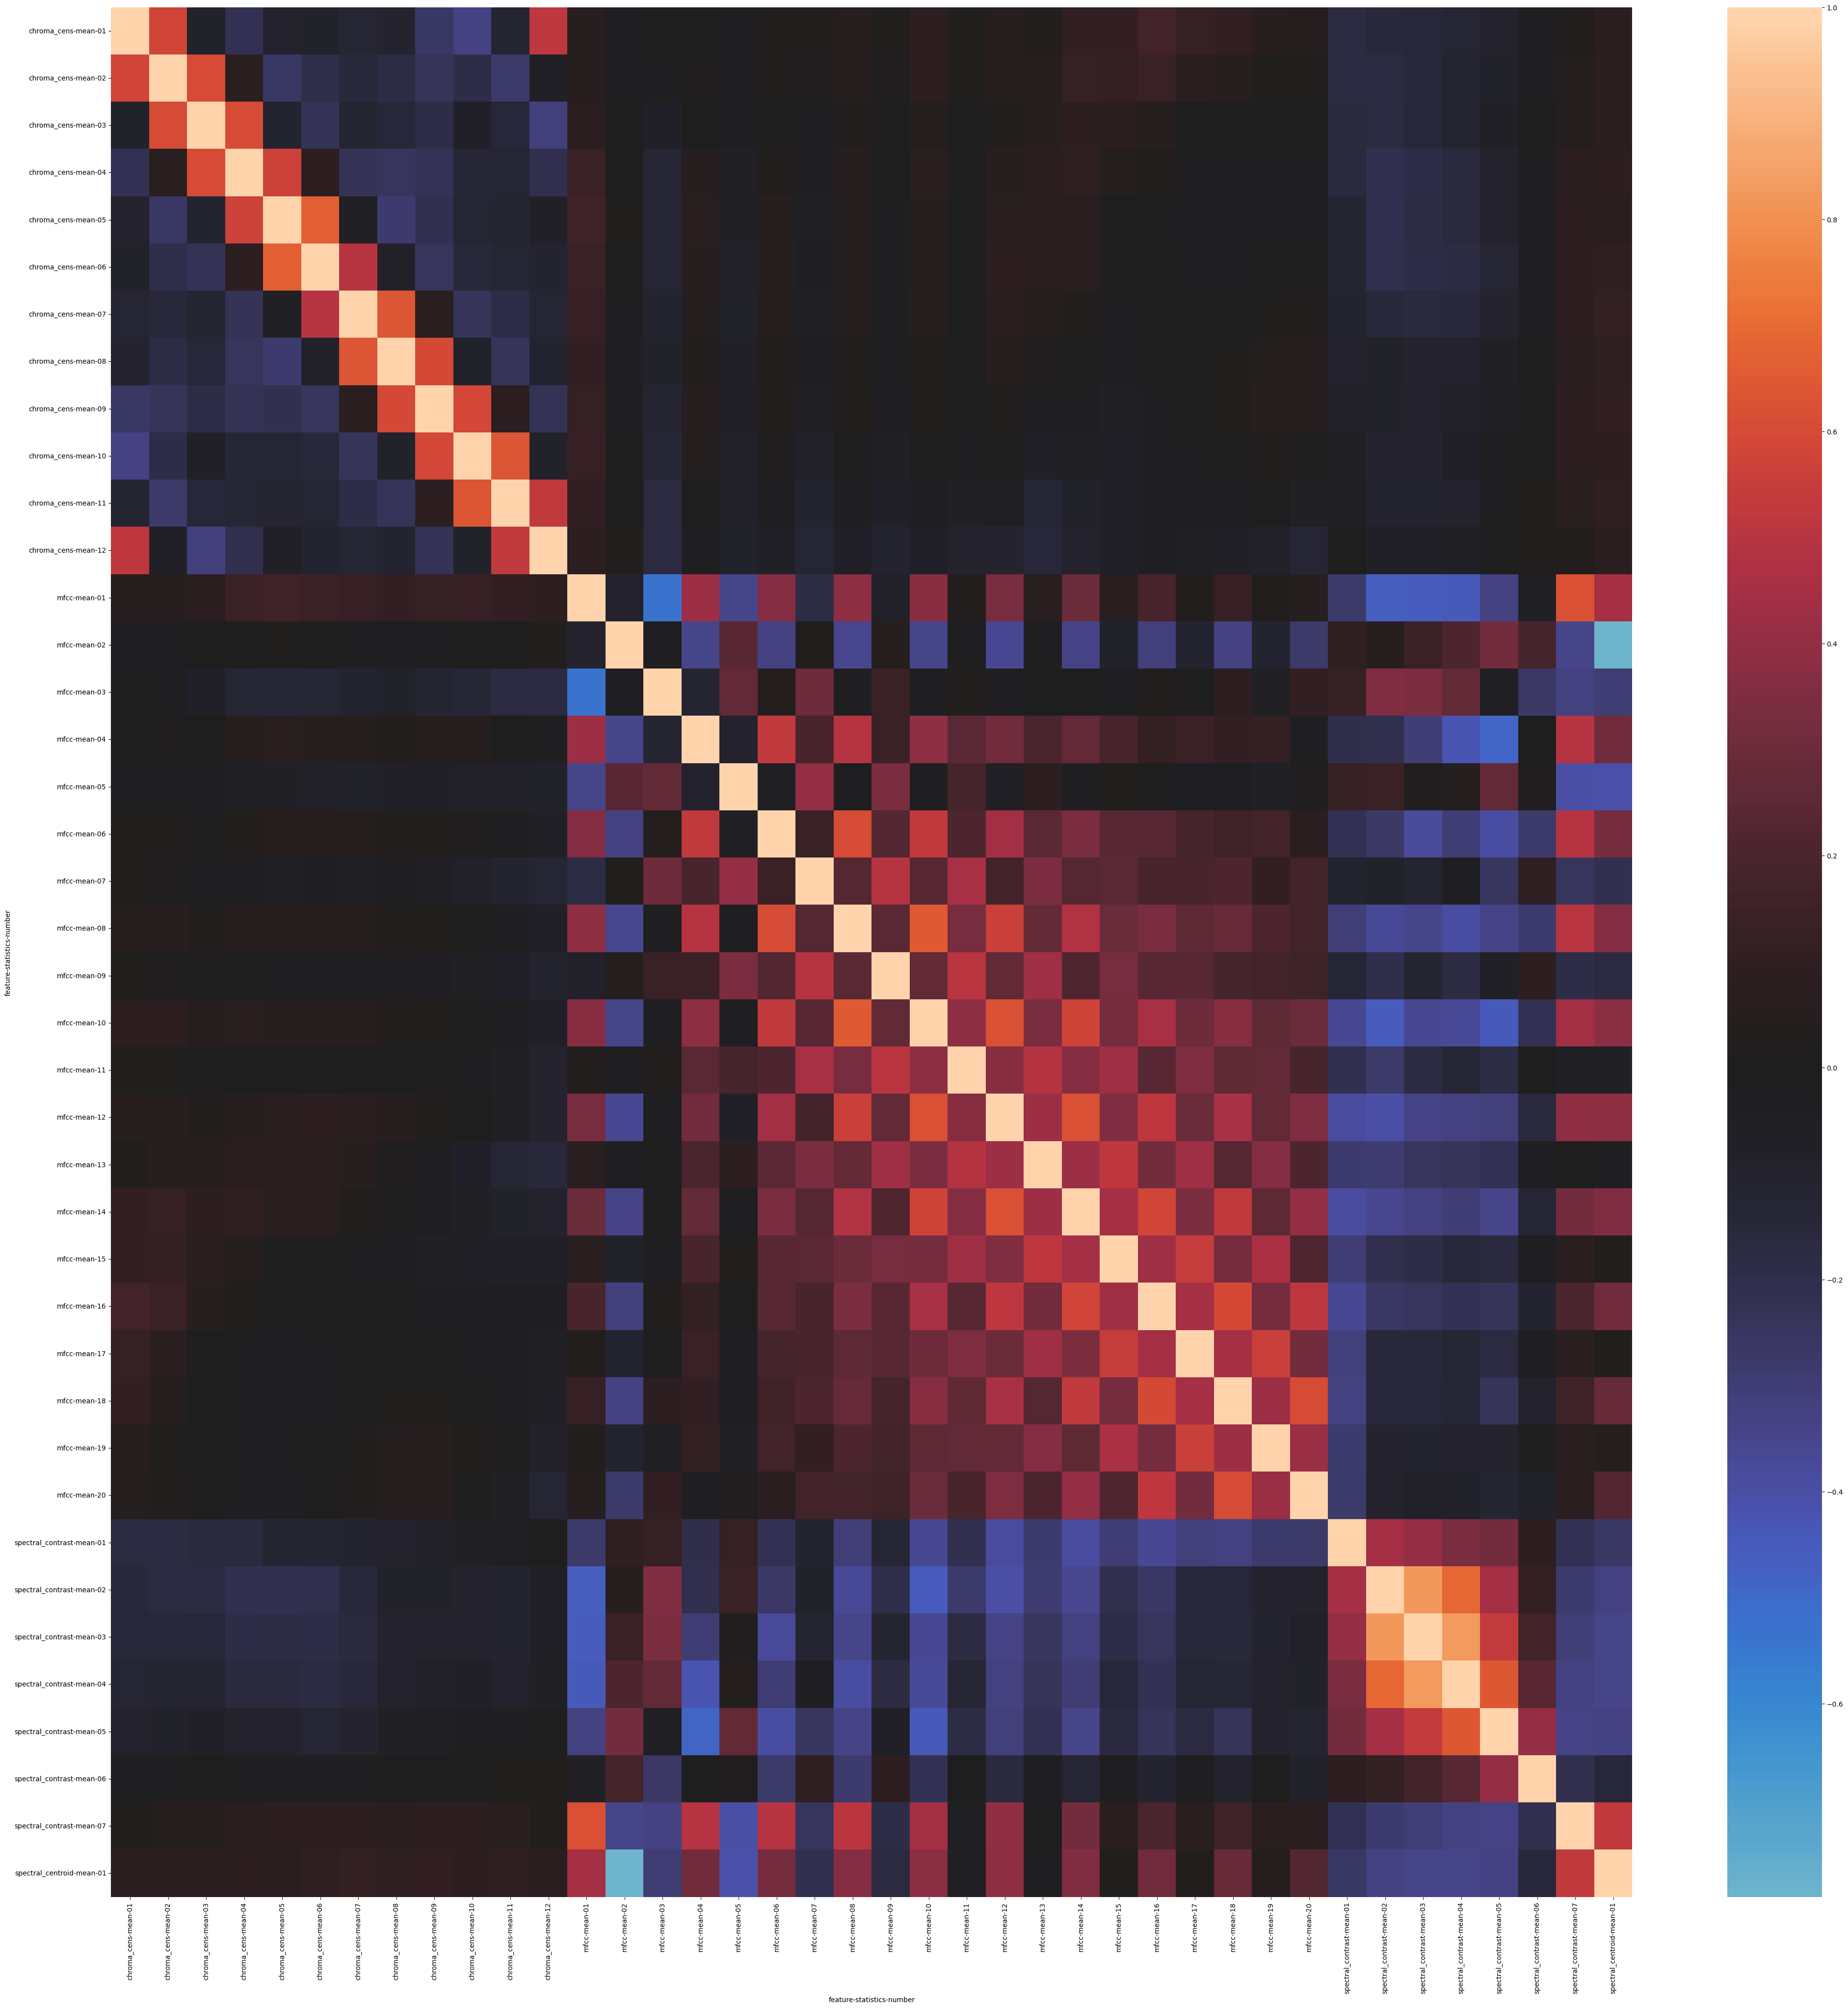

In [9]:
'''
code in this cell is taken and referenced from
https://scikit-learn.org/stable/modules/preprocessing.html and
https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/ and
https://www.kaggle.com/code/muki2003/randomforest-music-genre-classification and
https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/ and
https://www.geeksforgeeks.org/plotting-correlation-matrix-using-python/ and
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html and
https://www.simplilearn.com/tutorials/python-tutorial/data-visualization-in-python
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
https://seaborn.pydata.org/generated/seaborn.heatmap.html
'''

# Create a correlation matrix using the selected features.

plt.figure(figsize=(50,50))
sns.heatmap(df_selected.corr(), annot=False, center=0)

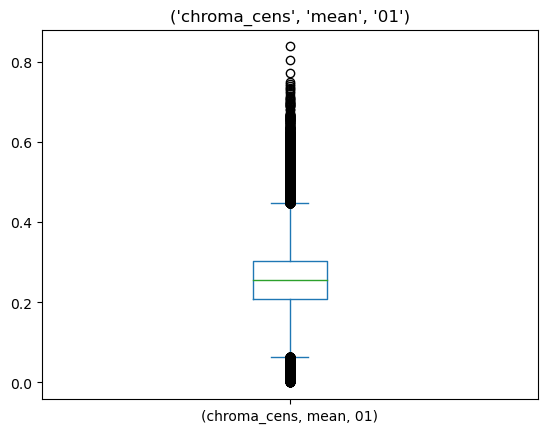

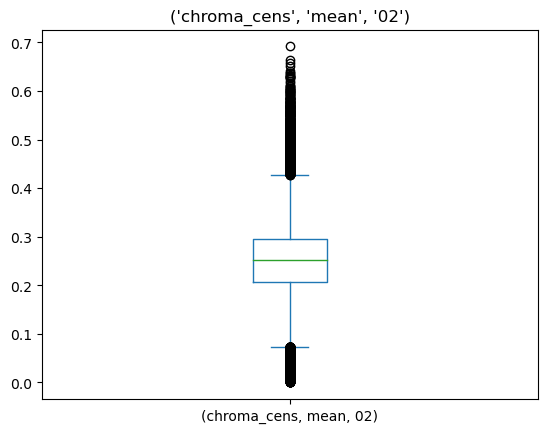

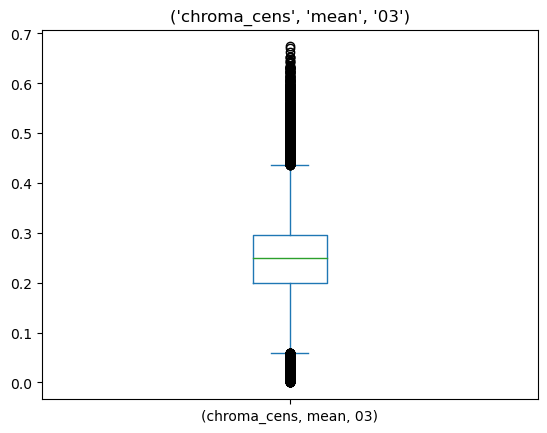

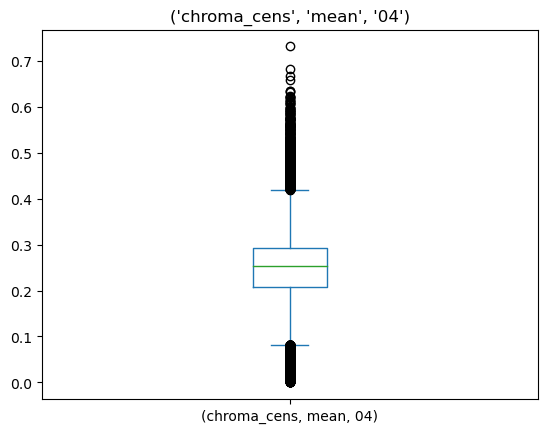

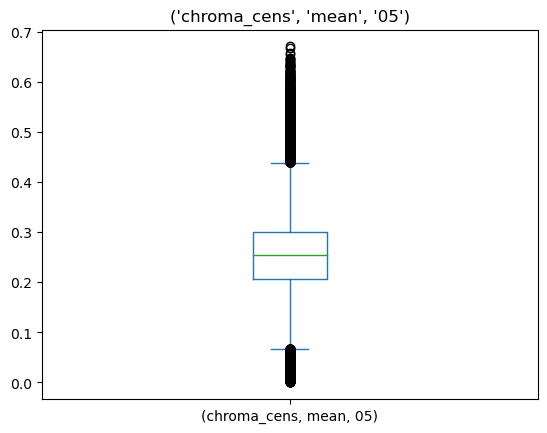

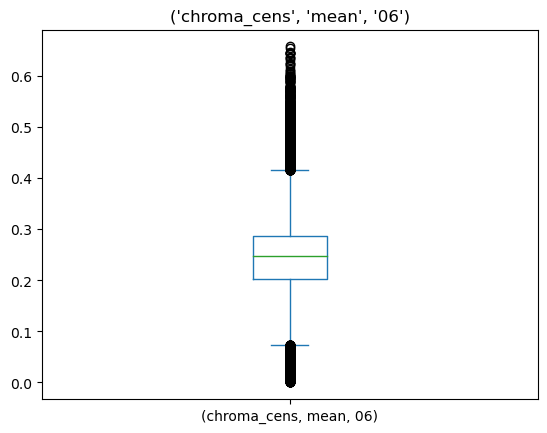

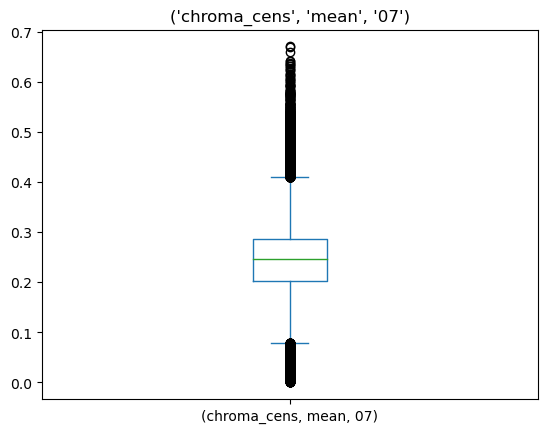

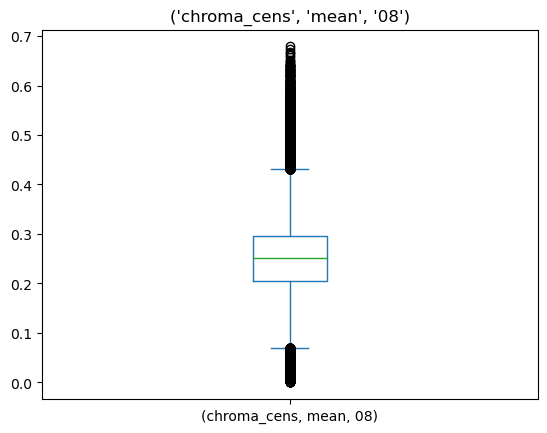

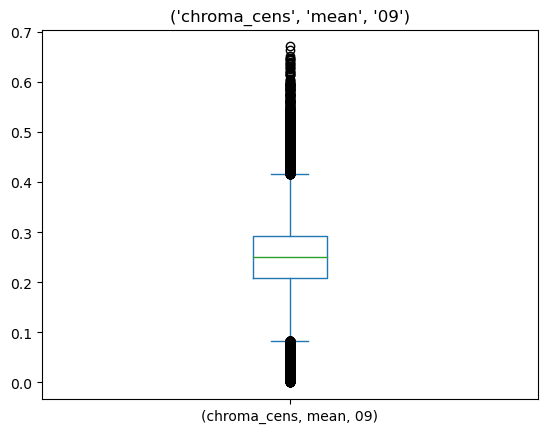

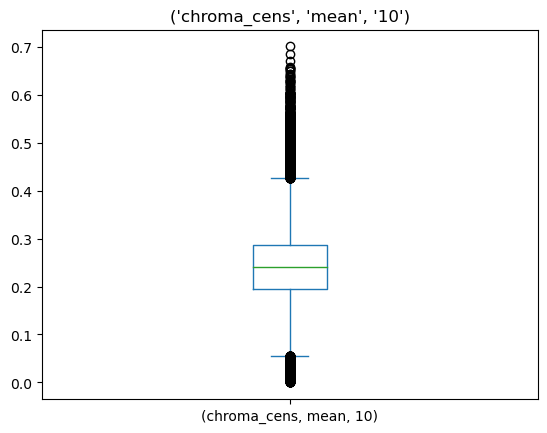

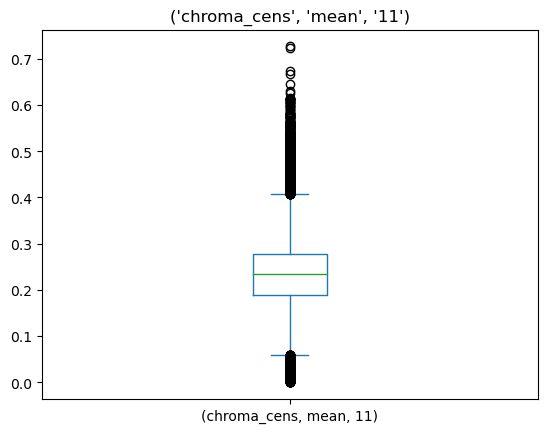

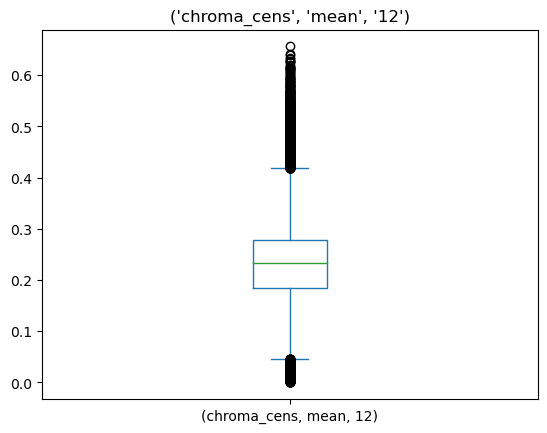

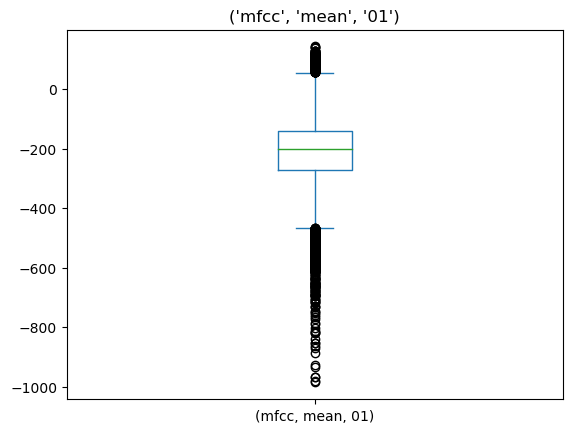

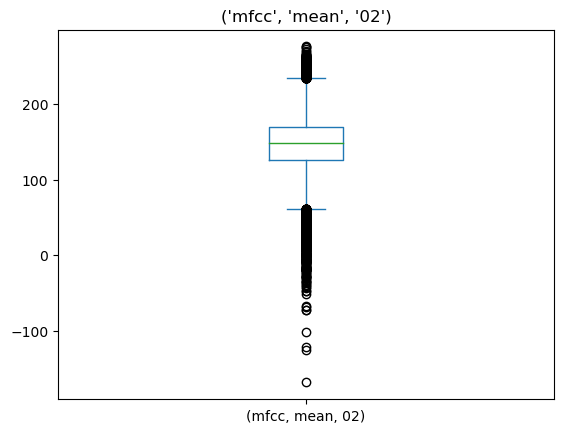

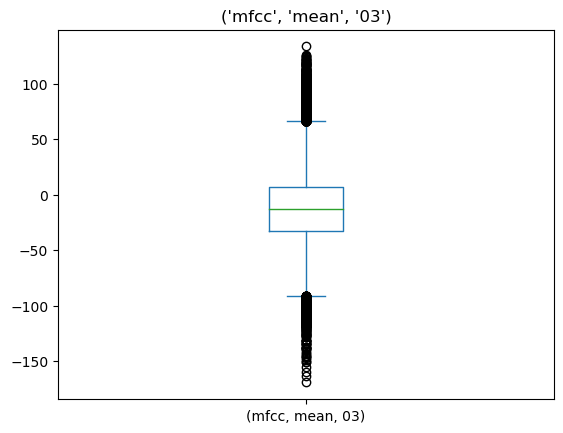

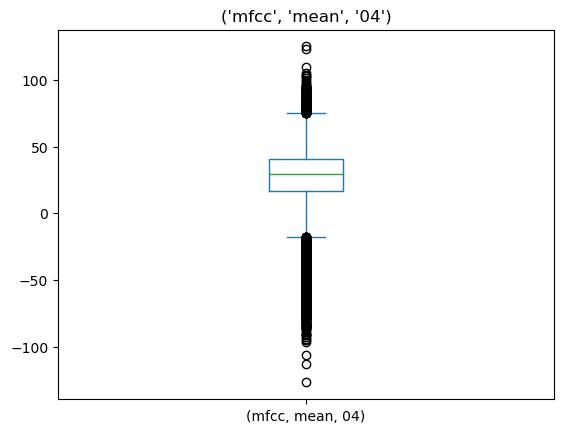

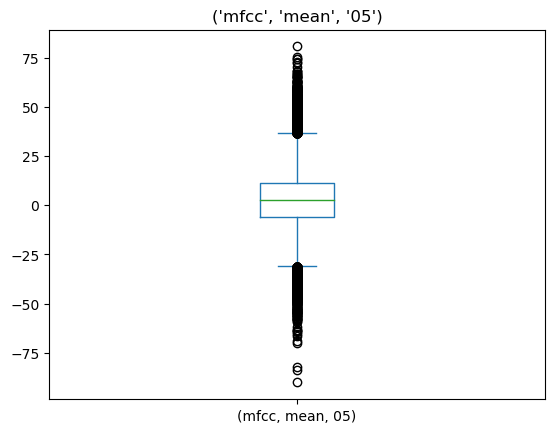

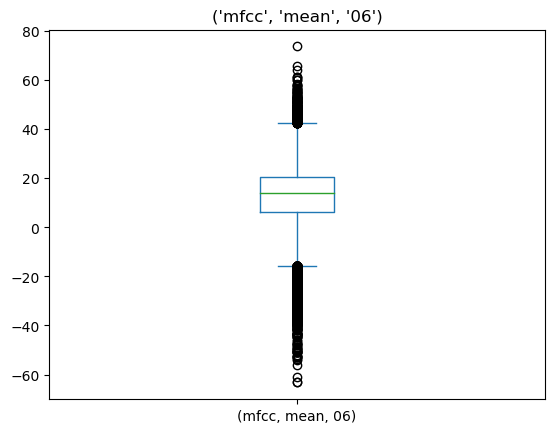

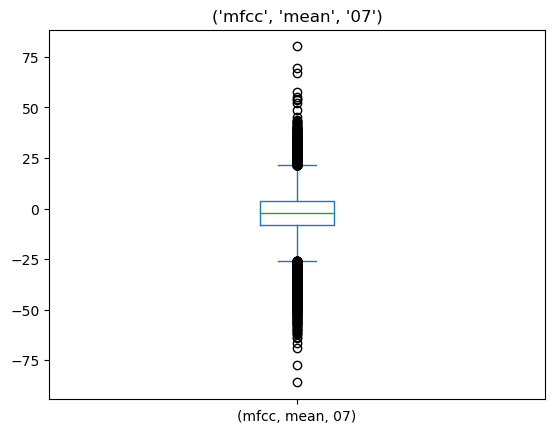

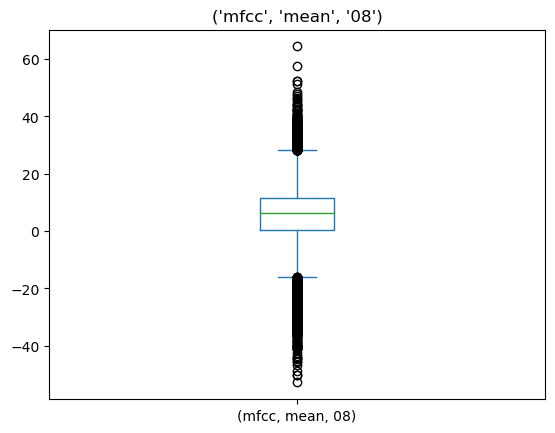

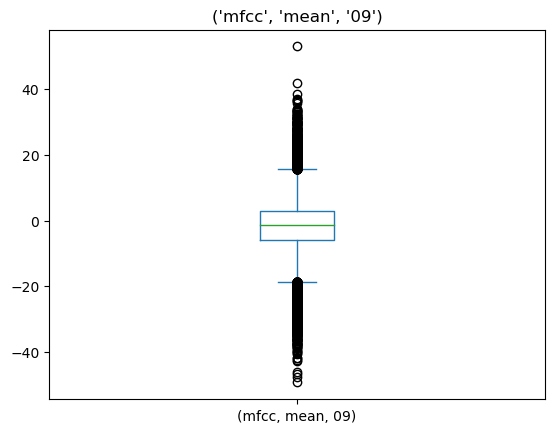

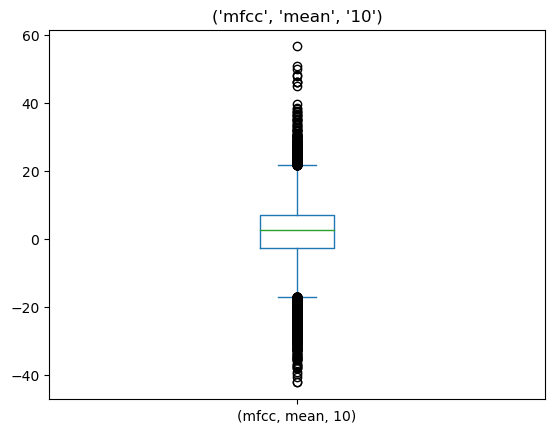

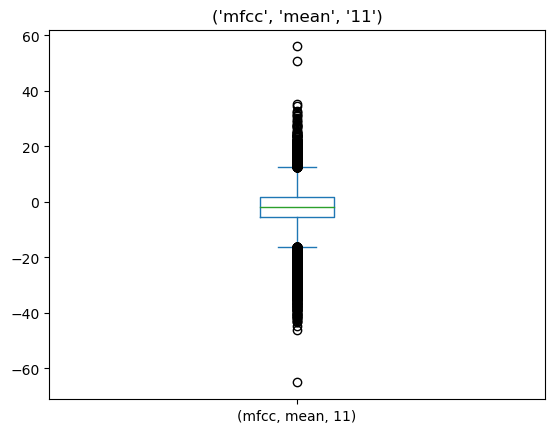

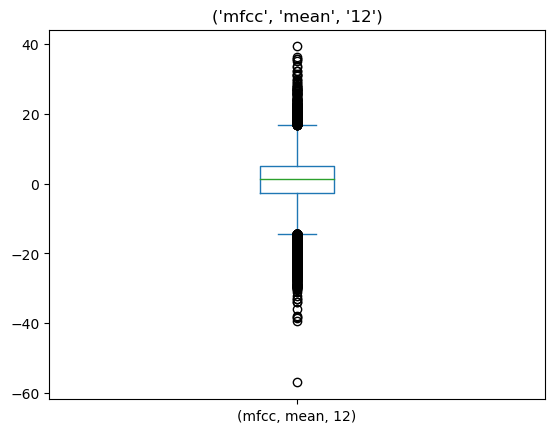

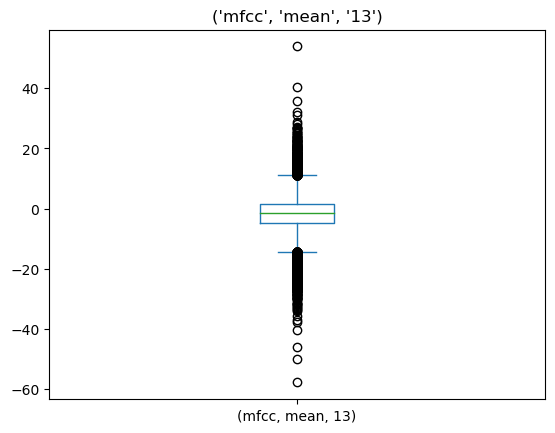

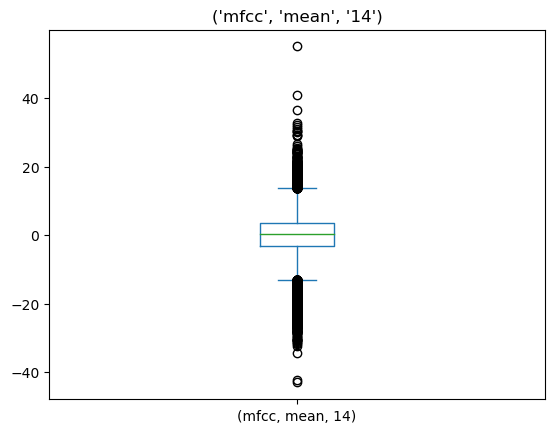

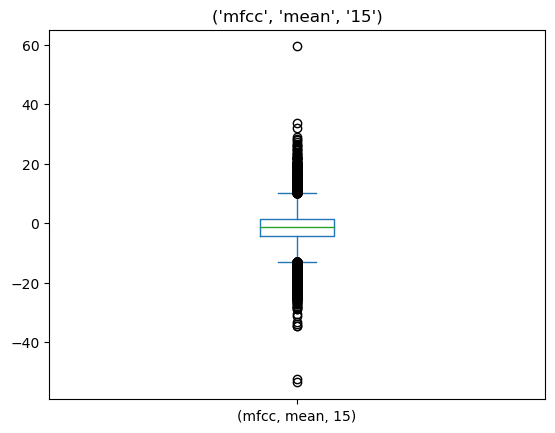

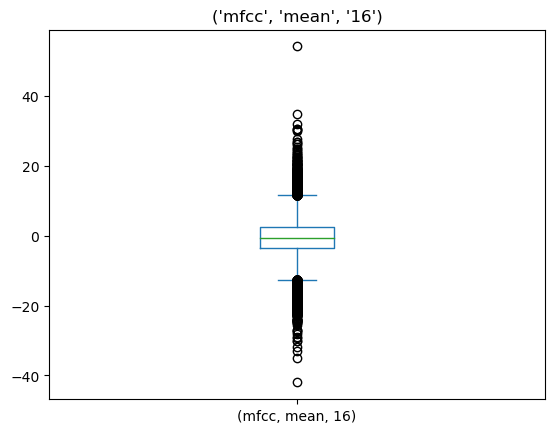

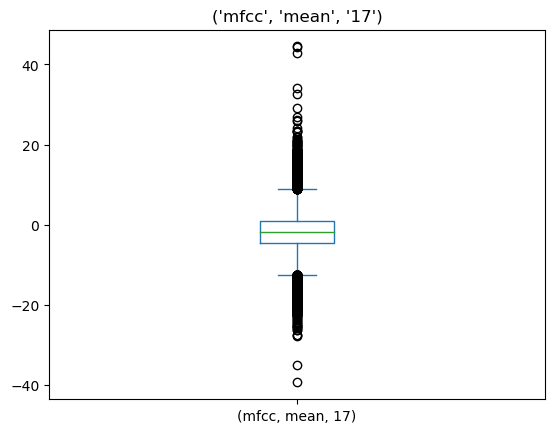

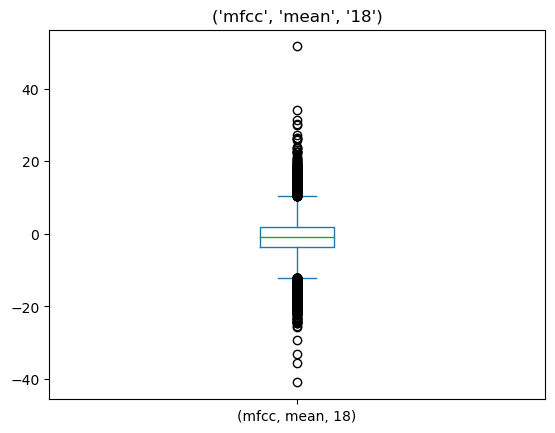

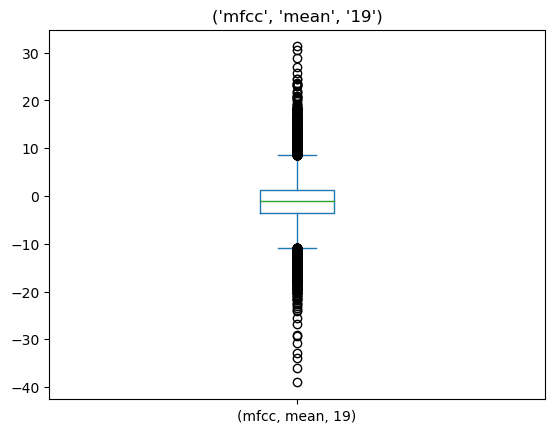

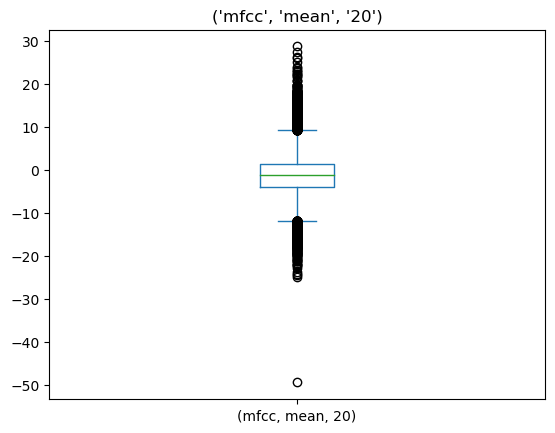

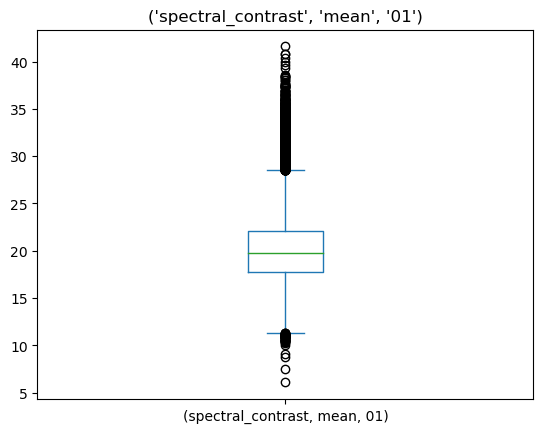

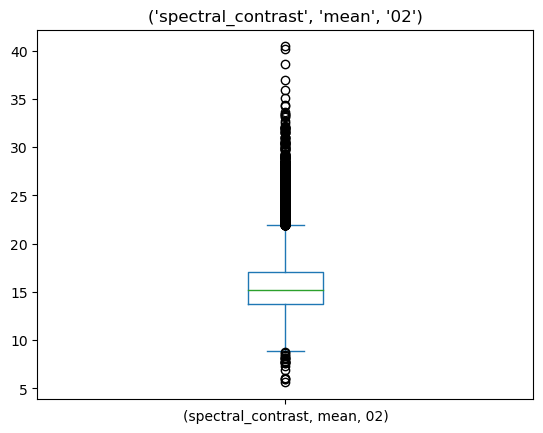

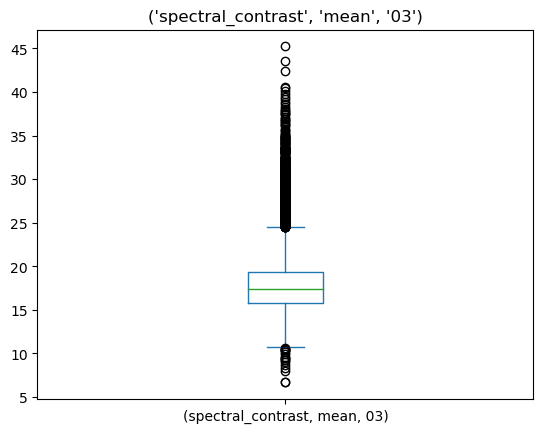

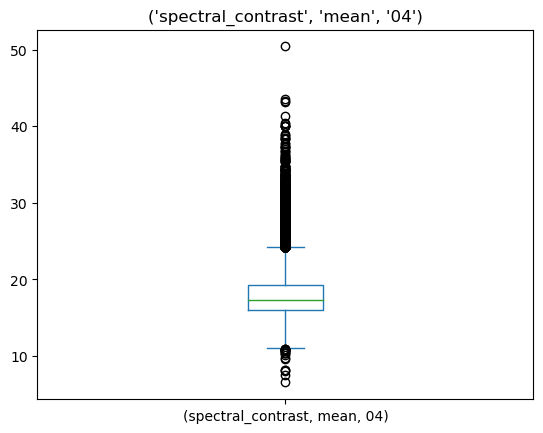

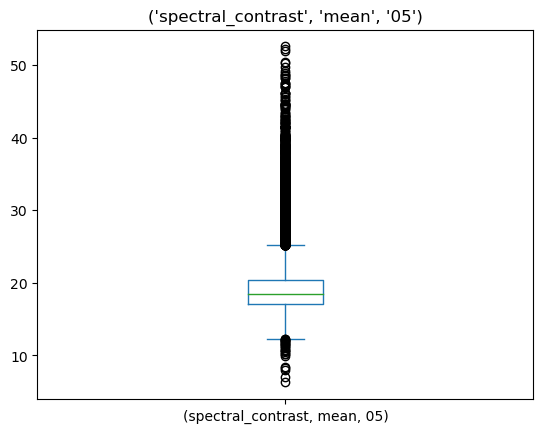

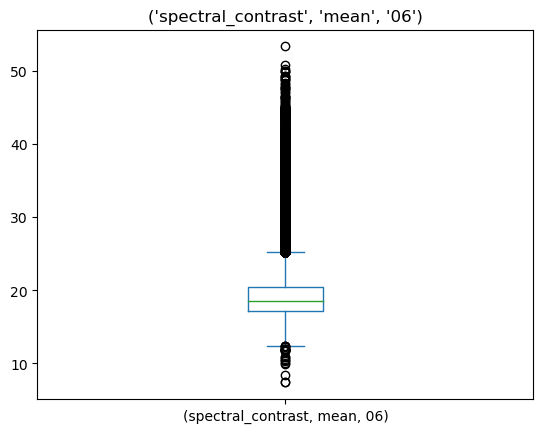

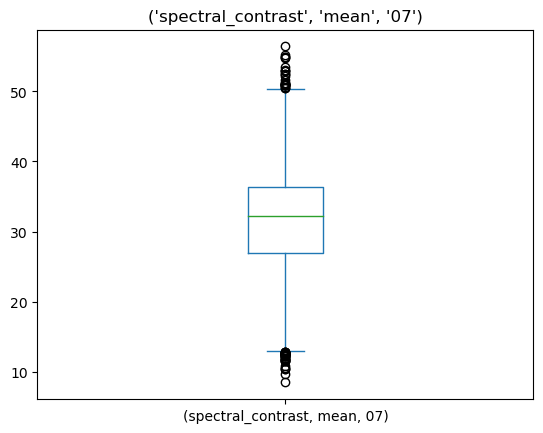

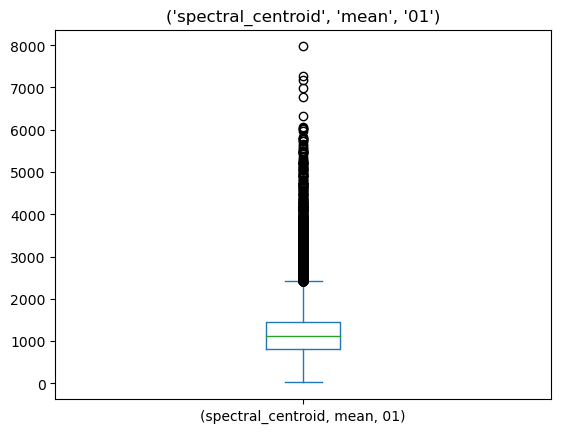

In [10]:
# Create a box plot for each of the descriptive features.

for name in df_selected.columns:
    plt.figure()
    df_selected[name].plot.box()
    plt.title(name)
    plt.show()

MODELING -->  K-NEAREST NEIGHBOUR ALGORITHM AND RANDOM FOREST ALGORITHM

K - NEAREST NEIGHBOUR ALGORITHM ON "SMALL" SIZED SUBSET OF DATA



In [11]:
'''
code in this cell is taken and referenced from
https://scikit-learn.org/stable/modules/preprocessing.html and
https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/ and
https://www.kaggle.com/code/muki2003/randomforest-music-genre-classification and
https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/ and
https://www.geeksforgeeks.org/plotting-correlation-matrix-using-python/ and
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html and
https://www.simplilearn.com/tutorials/python-tutorial/data-visualization-in-python and
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html and
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
'''

# Use kNN on the predefined "small" subset (a balanced subset of ~8000 tracks with 8 genres).

# Get the indexes of the instances in the subsets.
small = tracks['set', 'subset'] == 'small'
val = tracks['set', 'split'] == 'validation'
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'

# Use the intersection to account for previously removed duplicate or uninformative instances.
train_indexes = df_selected.index.intersection(tracks[small & train].index)
val_indexes = df_selected.index.intersection(tracks[small & val].index)
test_indexes = df_selected.index.intersection(tracks[small & test].index)

# Select and standardize the features (kNN is sensitive to their scales).
X_train = df_selected.loc[train_indexes]
X_val = df_selected.loc[val_indexes]
X_test = df_selected.loc[test_indexes]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Select the target levels and encode them (since genre is categorical).
y_train = tracks.loc[train_indexes, ('track', 'genre_top')]
y_val = tracks.loc[val_indexes, ('track', 'genre_top')]
y_test = tracks.loc[test_indexes, ('track', 'genre_top')]

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

# Fine-tune the value for K using the validation set.
best_score = 0
best_k = 1
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_encoded)
    score = knn.score(X_val_scaled, y_val_encoded)

    if score > best_score:
        best_score = score
        best_k = k

print("Best value for K:", best_k)

knn_adjusted = KNeighborsClassifier(n_neighbors=best_k)
knn_adjusted.fit(X_train_scaled, y_train_encoded)

# Make predictions using the test set.
y_test_predicted = knn_adjusted.predict(X_test_scaled)
score = accuracy_score(y_test_encoded, y_test_predicted)
print("Test set accuracy: {:.2%}".format(score))

Best value for K: 22
Test set accuracy: 36.08%


Text(120.72222222222221, 0.5, 'Actual')

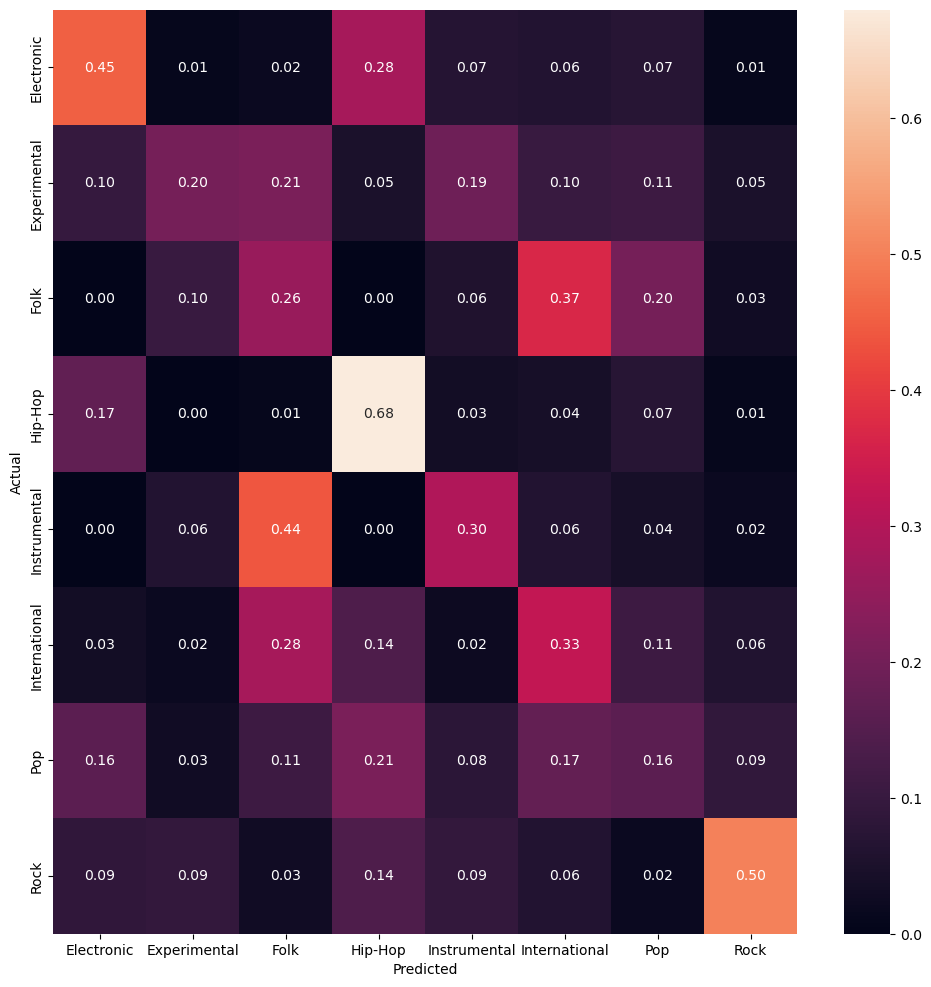

In [12]:
# Create a confusion matrix for the descriptive features.

matrix = confusion_matrix(y_test_encoded, y_test_predicted)
matrix = matrix / matrix.sum(axis=1)

plt.figure(figsize=(12, 12))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [13]:
f1_scores = f1_score(y_test_encoded, y_test_predicted, average=None)
f1_df = pd.DataFrame({'Genre': encoder.classes_, 'F1 Score': f1_scores})
f1_df = f1_df.sort_values(by='F1 Score', ascending=False)
f1_df

Genre  F1 Score
7           Rock  0.564972
3        Hip-Hop  0.544000
0     Electronic  0.451613
4   Instrumental  0.320988
5  International  0.297674
1   Experimental  0.268456
2           Folk  0.220339
6            Pop  0.180791

Text(0.5, 1.0, 'F1 Scores per genre')

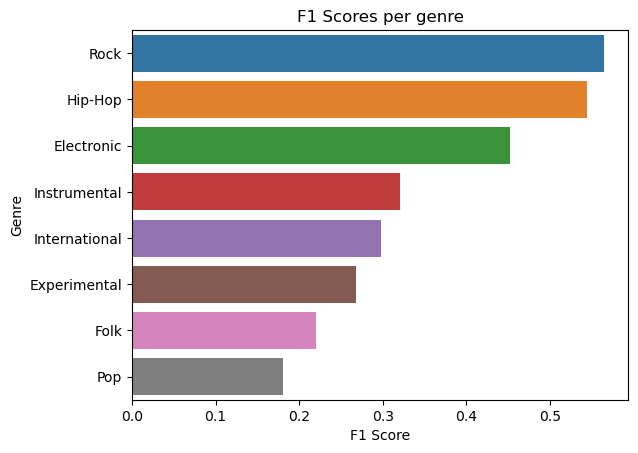

In [14]:
# Create a bar plot using the sorted DataFrame
sns.barplot(x='F1 Score', y='Genre', data=f1_df)
plt.xlabel('F1 Score')
plt.ylabel('Genre')
plt.title('F1 Scores per genre')

RANDOM FOREST ALGORITHM ON "SMALL" SIZED SUBSET OF DATA

In [15]:
'''
code in this cell is taken and referenced from
https://scikit-learn.org/stable/modules/preprocessing.html and
https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/ and
https://www.kaggle.com/code/muki2003/randomforest-music-genre-classification and
https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/ and
https://www.geeksforgeeks.org/plotting-correlation-matrix-using-python/ and
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html and
https://www.simplilearn.com/tutorials/python-tutorial/data-visualization-in-python and
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html and
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html and
https://seaborn.pydata.org/generated/seaborn.heatmap.html
'''

# Use random forest on the "small" subset using only the 40 selected features.

X_train, X_test, y_train, y_test = train_test_split(df_selected.loc[small], tracks[small][('track', 'genre_top')], test_size=0.2, random_state=42)

# Train the model.
forest = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap = False)
forest.fit(X_train, y_train)

# Make predictions using the test set.
y_test_predicted = forest.predict(X_test)
score = accuracy_score(y_test, y_test_predicted)
print("Test set accuracy: {:.2%}".format(score))

Test set accuracy: 51.97%


Text(120.72222222222221, 0.5, 'Actual')

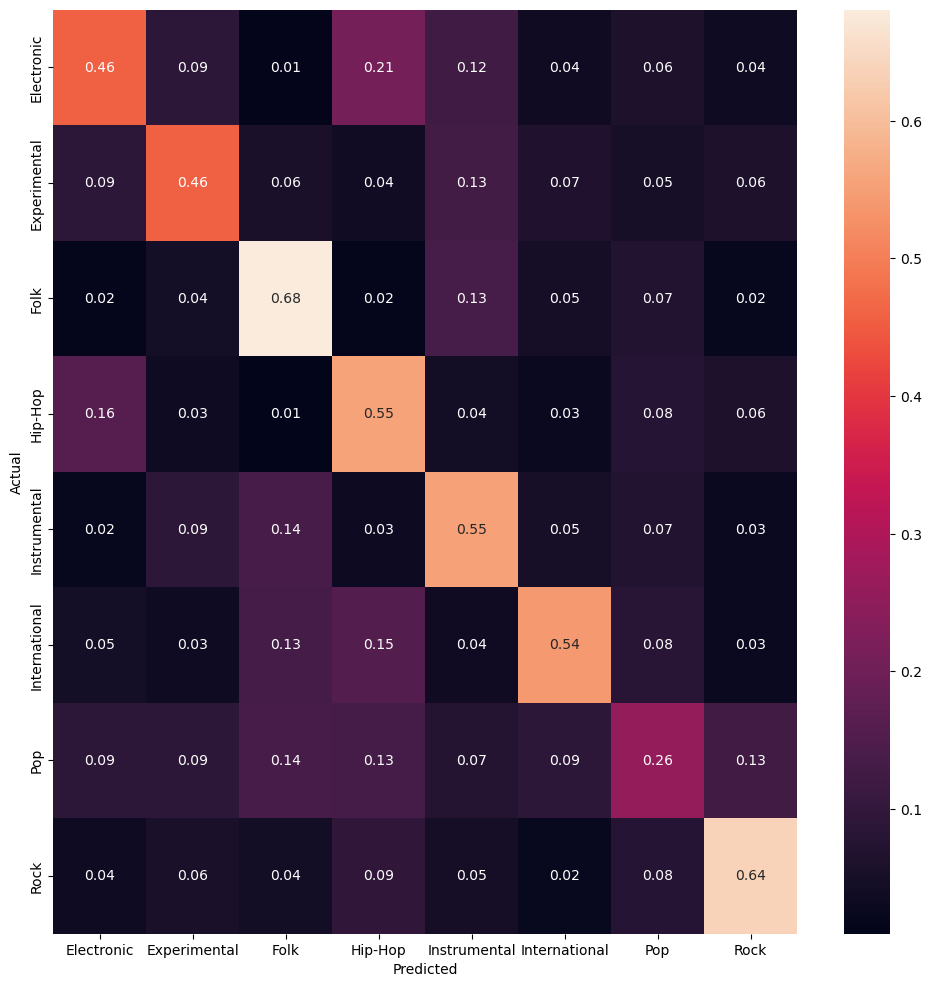

In [16]:
# Create a confusion matrix for the descriptive features.

matrix = confusion_matrix(y_test, y_test_predicted)
matrix = matrix / matrix.sum(axis=1)

plt.figure(figsize=(12, 12))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [17]:
f1_scores = f1_score(y_test, y_test_predicted, average=None)
f1_df = pd.DataFrame({'Genre': encoder.classes_, 'F1 Score': f1_scores})
f1_df = f1_df.sort_values(by='F1 Score', ascending=False)
f1_df

Genre  F1 Score
7           Rock  0.637975
2           Folk  0.617021
5  International  0.574257
4   Instrumental  0.518160
3        Hip-Hop  0.497537
1   Experimental  0.482353
0     Electronic  0.477690
6            Pop  0.297376

Text(0.5, 1.0, 'F1 Scores per genre')

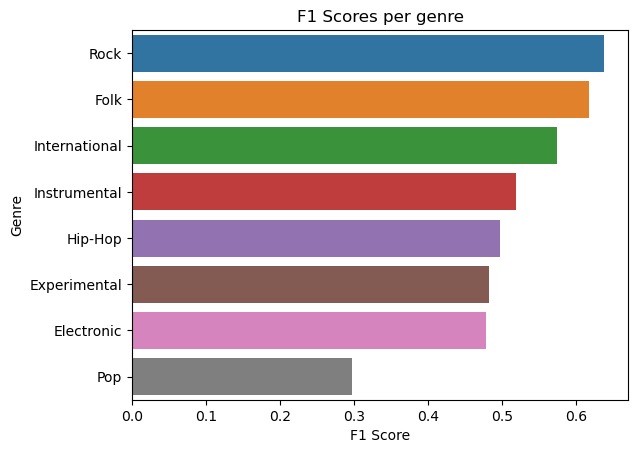

In [18]:
# Create a bar chart showing F1 scores.

# Create a bar plot using the sorted DataFrame
sns.barplot(x='F1 Score', y='Genre', data=f1_df)
plt.xlabel('F1 Score')
plt.ylabel('Genre')
plt.title('F1 Scores per genre')

K - NEAREST NEIGHBOUR ALGORITHM ON "MEDIUM" SIZED SUBSET OF DATA



In [19]:
'''
code in this cell is taken and referenced from
https://scikit-learn.org/stable/modules/preprocessing.html and
https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/ and
https://www.kaggle.com/code/muki2003/randomforest-music-genre-classification and
https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/ and
https://www.geeksforgeeks.org/plotting-correlation-matrix-using-python/ and
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html and
https://www.simplilearn.com/tutorials/python-tutorial/data-visualization-in-python and
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html and
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
'''

# Use kNN on the predefined "medium" subset (an balanced subset of ~25,000 tracks with 16 genres).

# Get the indexes of the instances in the subsets.
medium = (tracks['set', 'subset'] == 'medium') | (tracks['set', 'subset'] == 'small')
val = tracks['set', 'split'] == 'validation'
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'

# Use the intersection to account for previously removed duplicate or uninformative instances.
train_indexes = df_selected.index.intersection(tracks[medium & train].index)
val_indexes = df_selected.index.intersection(tracks[medium & val].index)
test_indexes = df_selected.index.intersection(tracks[medium & test].index)

# Select and standardize the features (kNN is sensitive to their scales).
X_train = df_selected.loc[train_indexes]
X_val = df_selected.loc[val_indexes]
X_test = df_selected.loc[test_indexes]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Select the target levels and encode them (since genre is categorical).
y_train = tracks.loc[train_indexes, ('track', 'genre_top')]
y_val = tracks.loc[val_indexes, ('track', 'genre_top')]
y_test = tracks.loc[test_indexes, ('track', 'genre_top')]

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

# Fine-tune the value for K using the validation set.
best_score = 0
best_k = 1
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_encoded)
    score = knn.score(X_val_scaled, y_val_encoded)

    if score > best_score:
        best_score = score
        best_k = k

print("Best value for K:", best_k)

knn_adjusted = KNeighborsClassifier(n_neighbors=best_k)
knn_adjusted.fit(X_train_scaled, y_train_encoded)

# Make predictions using the test set.
y_test_predicted = knn_adjusted.predict(X_test_scaled)
score = accuracy_score(y_test_encoded, y_test_predicted)
print("Test set accuracy: {:.2%}".format(score))

Best value for K: 32
Test set accuracy: 52.96%


Text(120.72222222222221, 0.5, 'Actual')

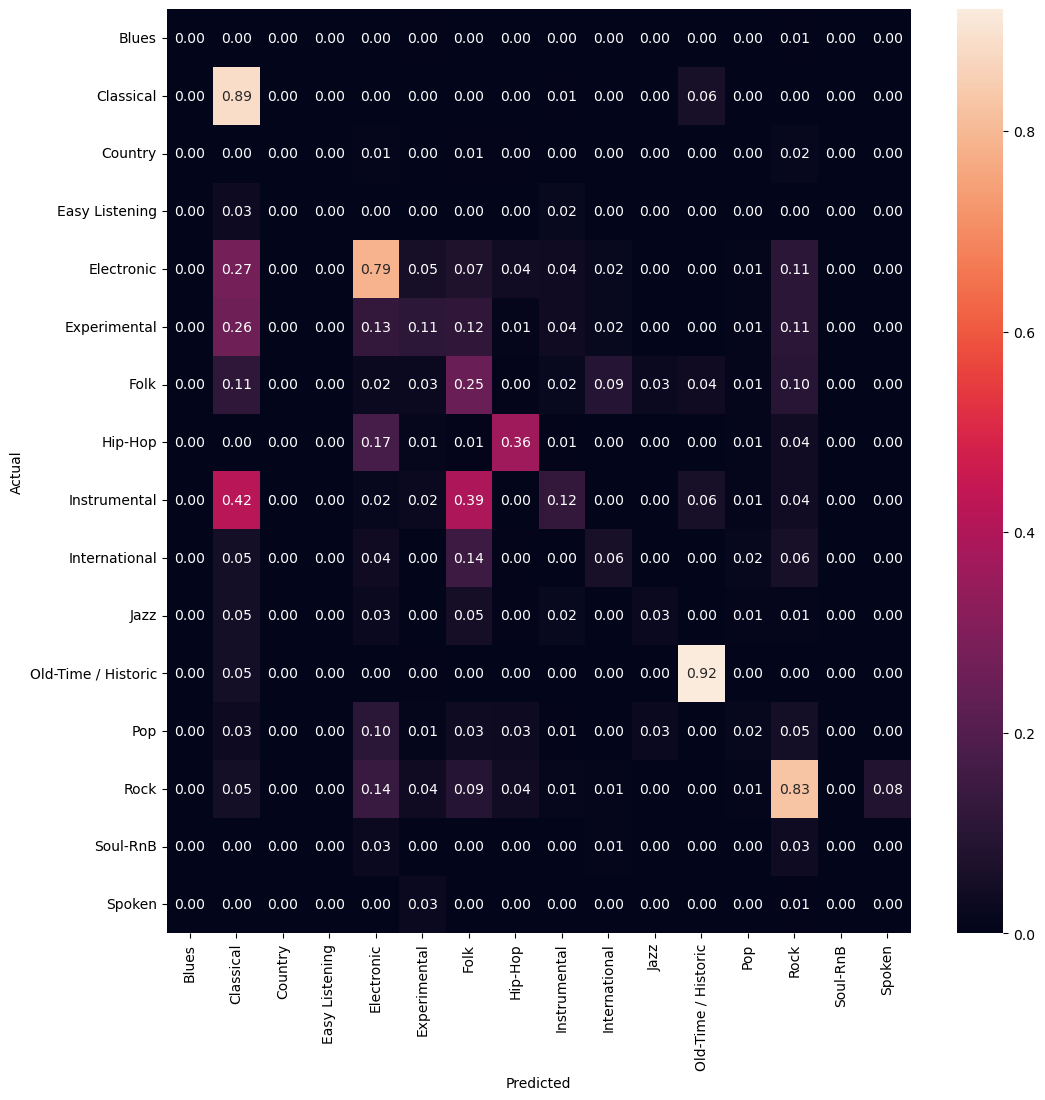

In [20]:
# Create a confusion matrix for the descriptive features.

matrix = confusion_matrix(y_test_encoded, y_test_predicted)
matrix = matrix / matrix.sum(axis=1)

plt.figure(figsize=(12, 12))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [21]:
f1_scores = f1_score(y_test_encoded, y_test_predicted, average=None)
f1_df = pd.DataFrame({'Genre': encoder.classes_, 'F1 Score': f1_scores})
f1_df = f1_df.sort_values(by='F1 Score', ascending=False)
f1_df

Genre  F1 Score
11  Old-Time / Historic  0.886792
13                 Rock  0.687167
4            Electronic  0.635046
1             Classical  0.552764
7               Hip-Hop  0.483384
6                  Folk  0.230303
8          Instrumental  0.190000
5          Experimental  0.165517
9         International  0.099174
10                 Jazz  0.047619
12                  Pop  0.031496
0                 Blues  0.000000
2               Country  0.000000
3        Easy Listening  0.000000
14             Soul-RnB  0.000000
15               Spoken  0.000000

Text(0.5, 1.0, 'F1 Scores per genre')

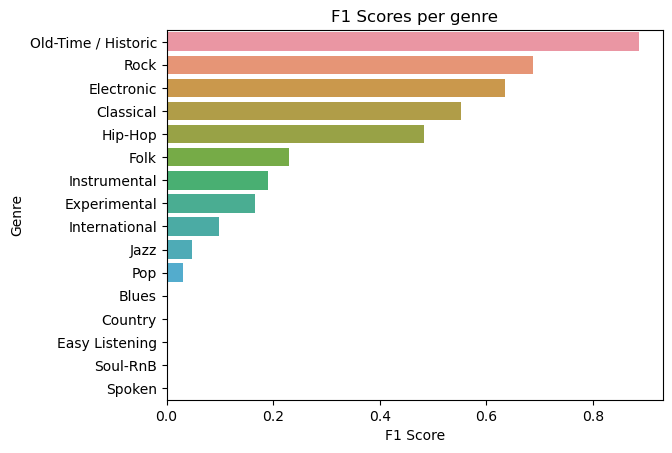

In [22]:
# Create a bar plot using the sorted DataFrame
sns.barplot(x='F1 Score', y='Genre', data=f1_df)
plt.xlabel('F1 Score')
plt.ylabel('Genre')
plt.title('F1 Scores per genre')

RANDOM FOREST ALGORITHM ON "MEDIUM" SIZED SUBSET OF DATA

In [23]:
'''
code in this cell is taken and referenced from
https://scikit-learn.org/stable/modules/preprocessing.html and
https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/ and
https://www.kaggle.com/code/muki2003/randomforest-music-genre-classification and
https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/ and
https://www.geeksforgeeks.org/plotting-correlation-matrix-using-python/ and
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html and
https://www.simplilearn.com/tutorials/python-tutorial/data-visualization-in-python and
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html and
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html and
https://seaborn.pydata.org/generated/seaborn.heatmap.html
'''

# Use random forest on the "medium" subset using only the 40 selected features.

X_train, X_test, y_train, y_test = train_test_split(df_selected.loc[medium], tracks[medium][('track', 'genre_top')], test_size=0.2, random_state=42)

# Train the model.
forest = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap = False)
forest.fit(X_train, y_train)

# Make predictions using the test set.
y_test_predicted = forest.predict(X_test)
score = accuracy_score(y_test, y_test_predicted)
print("Test set accuracy: {:.2%}".format(score))

Test set accuracy: 60.26%


Text(120.72222222222221, 0.5, 'Actual')

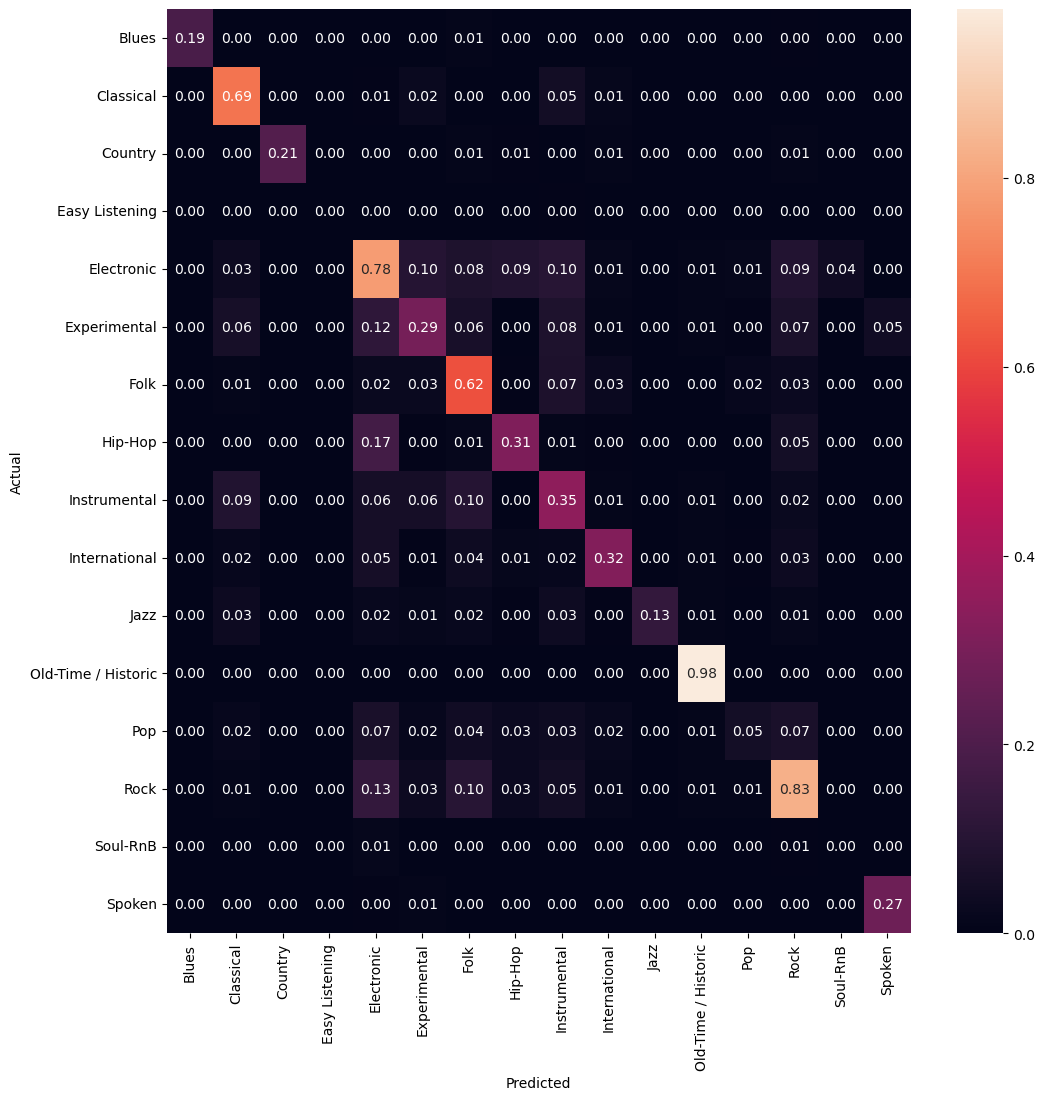

In [24]:
# Create a confusion matrix for the descriptive features.

matrix = confusion_matrix(y_test, y_test_predicted)
matrix = matrix / matrix.sum(axis=1)

plt.figure(figsize=(12, 12))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [25]:
f1_scores = f1_score(y_test, y_test_predicted, average=None)
f1_df = pd.DataFrame({'Genre': encoder.classes_, 'F1 Score': f1_scores})
f1_df = f1_df.sort_values(by='F1 Score', ascending=False)
f1_df

Genre  F1 Score
11  Old-Time / Historic  0.952880
13                 Rock  0.743307
1             Classical  0.707424
4            Electronic  0.635891
6                  Folk  0.590267
9         International  0.442953
7               Hip-Hop  0.419106
15               Spoken  0.413793
8          Instrumental  0.389610
5          Experimental  0.368421
2               Country  0.350000
0                 Blues  0.315789
10                 Jazz  0.234043
12                  Pop  0.091954
3        Easy Listening  0.000000
14             Soul-RnB  0.000000

Text(0.5, 1.0, 'F1 Scores per genre')

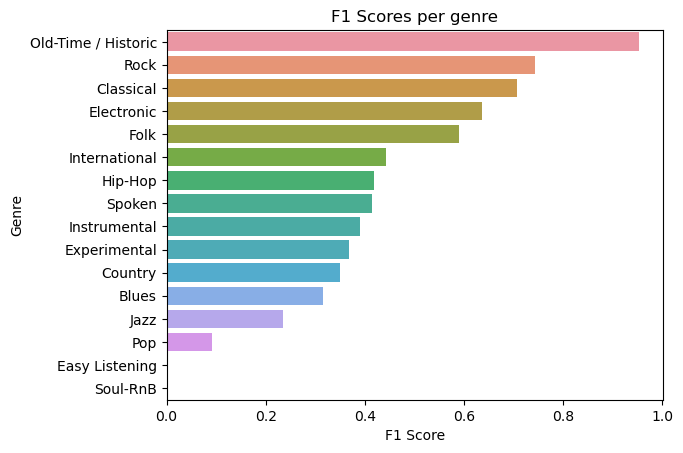

In [26]:
# Create a bar chart showing F1 scores.

f1_scores = f1_score(y_test, y_test_predicted, average=None)
f1_df = pd.DataFrame({'Genre': encoder.classes_, 'F1 Score': f1_scores})
f1_df = f1_df.sort_values(by='F1 Score', ascending=False)

# Create a bar plot using the sorted DataFrame
sns.barplot(x='F1 Score', y='Genre', data=f1_df)
plt.xlabel('F1 Score')
plt.ylabel('Genre')
plt.title('F1 Scores per genre')

                                        REFERENCES


[1] Chartio.com. “How to Check If Any Value Is Nan in a Pandas DataFrame.” Available: https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/. [Accessed: December 10, 2023].

[2] Geeksforgeeks.org. “ML: Data Preprocessing in Python.” Available: https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/, June 10, 2023. [Accesed: December 10, 2023].

[3] Geeksforgeeks.org. “Plotting Correlation Matrix Using Python.” Available: https://www.geeksforgeeks.org/plotting-correlation-matrix-using-python/, Aug. 26, 2022. [Accessed: December 10, 2023].

[4] Kaggle.com. “[RandomForest] Music-Genre-Classification.” Available: https://www.kaggle.com/code/muki2003/randomforest-music-genre-classification, June 28, 2022. [Accessed: December 10, 2023].

[5] Matplotlib.org. “Matplotlib.pyplot.figure.” Available: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html. [Accesed: December 10, 2023].

[6] Scikit-learn.org. “6.3. Preprocessing Data.” Available: https://scikit-learn.org/stable/modules/preprocessing.html. [Accesed: December 10, 2023].

[7] Scikit-learn.org. “sklearn.preprocessing.StandardScaler” Available: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html. [Accesed: December 10, 2023].

[8] Scikit-learn.org. “sklearn.ensemble.RandomForestClassifier” Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. [Accesed: December 10, 2023].

[9] Scikit-learn.org. “sklearn.neighbors.KNeighborsClassifier” Available: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier. [Accesed: December 10, 2023].

[10] Seaborn.pydata.org. “Seaborn.heatmap.” Available: https://seaborn.pydata.org/generated/seaborn.heatmap.html. [Accesed: December 10, 2023].

[11] Simplilearn.com. “A Complete Guide to Data Visualization in Python With Libraries & More.” Available: https://www.simplilearn.com/tutorials/python-tutorial/data-visualization-in-python, May 18, 2023. [Accesed: December 10, 2023].
